In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA DE TORAX.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=204.2, y1=102.1
Page 1, Q1, A: Yellow pixels: 187
Page 1, Q1, A: Total non-white pixels: 855
Page 1, Q1, A: Yellow percentage: 21.9%


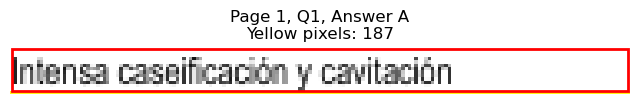

Page 1, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=242.9, y1=114.7
Page 1, Q1, B: Yellow pixels: 2089
Page 1, Q1, B: Total non-white pixels: 2782
Page 1, Q1, B: Yellow percentage: 75.1%


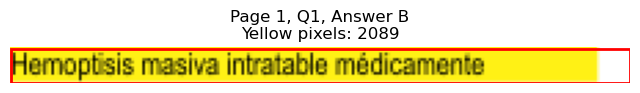

Page 1, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=491.0, y1=102.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 847
Page 1, Q1, C: Yellow percentage: 0.0%


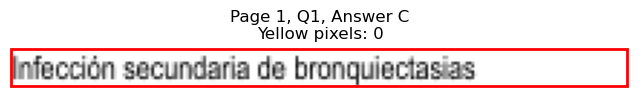

Page 1, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=471.5, y1=114.7
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 739
Page 1, Q1, D: Yellow percentage: 0.0%


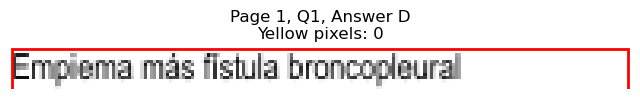


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=142.0, y1=190.4
Page 1, Q2, A: Yellow pixels: 124
Page 1, Q2, A: Total non-white pixels: 489
Page 1, Q2, A: Yellow percentage: 25.4%


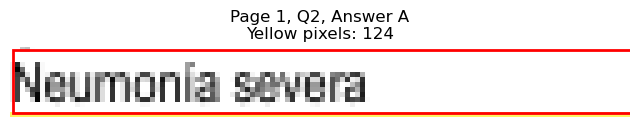

Page 1, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=235.8, y1=203.0
Page 1, Q2, B: Yellow pixels: 2102
Page 1, Q2, B: Total non-white pixels: 2782
Page 1, Q2, B: Yellow percentage: 75.6%


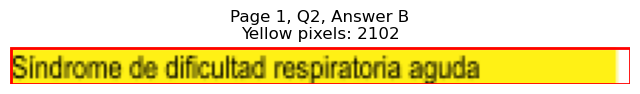

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=391.7, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 333
Page 1, Q2, C: Yellow percentage: 0.0%


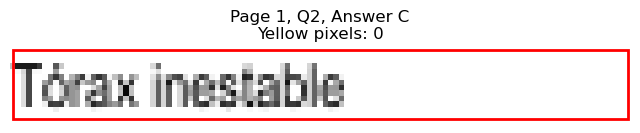

Page 1, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=425.8, y1=203.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 529
Page 1, Q2, D: Yellow percentage: 0.0%


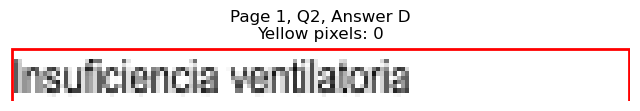


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=178.6, y1=240.9
Page 1, Q3, A: Yellow pixels: 1650
Page 1, Q3, A: Total non-white pixels: 2093
Page 1, Q3, A: Yellow percentage: 78.8%


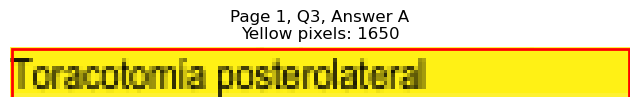

Page 1, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=145.6, y1=253.5
Page 1, Q3, B: Yellow pixels: 127
Page 1, Q3, B: Total non-white pixels: 511
Page 1, Q3, B: Yellow percentage: 24.9%


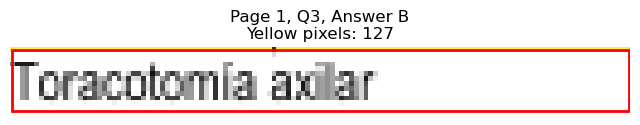

Page 1, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=391.7, y1=240.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 320
Page 1, Q3, C: Yellow percentage: 0.0%


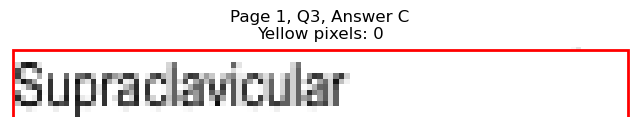

Page 1, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=383.7, y1=253.5
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 294
Page 1, Q3, D: Yellow percentage: 0.0%


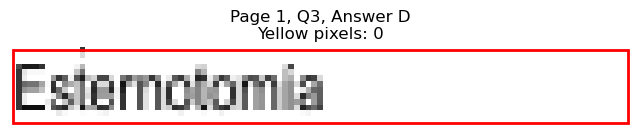


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=65.2, y1=316.7
Page 1, Q4, A: Yellow pixels: 731
Page 1, Q4, A: Total non-white pixels: 780
Page 1, Q4, A: Yellow percentage: 93.7%


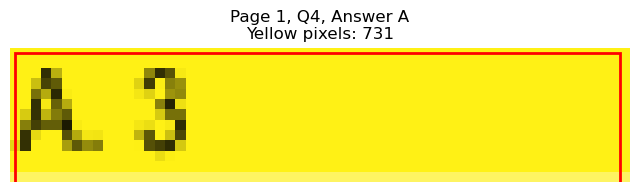

Page 1, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=65.2, y1=329.3
Page 1, Q4, B: Yellow pixels: 60
Page 1, Q4, B: Total non-white pixels: 126
Page 1, Q4, B: Yellow percentage: 47.6%


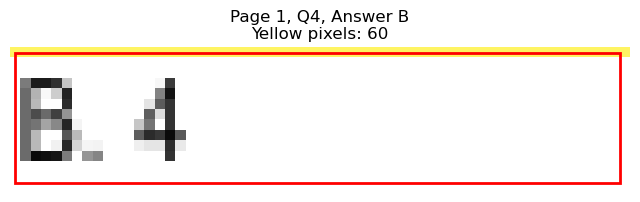

Page 1, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=324.4, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 62
Page 1, Q4, C: Yellow percentage: 0.0%


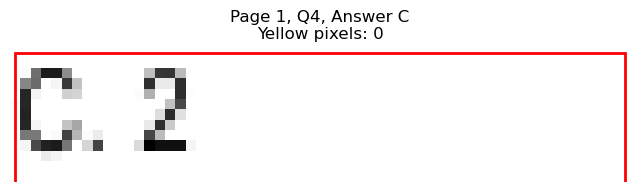

Page 1, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=324.4, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 53
Page 1, Q4, D: Yellow percentage: 0.0%


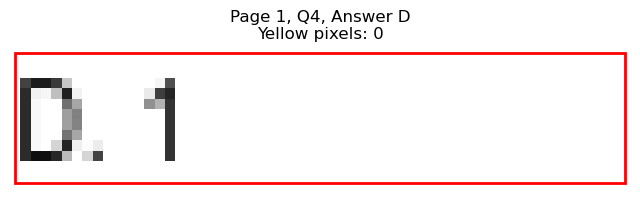


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=133.5, y1=379.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 340
Page 1, Q5, A: Yellow percentage: 0.0%


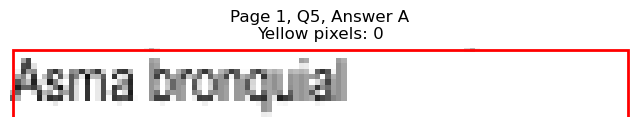

Page 1, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=142.5, y1=392.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 349
Page 1, Q5, B: Yellow percentage: 0.0%


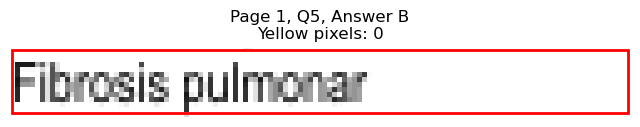

Page 1, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=497.0, y1=379.8
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 1053
Page 1, Q5, C: Yellow percentage: 0.0%


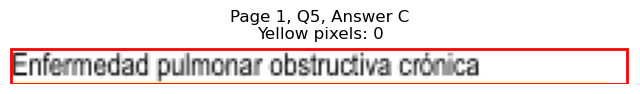

Page 1, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=404.3, y1=392.4
Page 1, Q5, D: Yellow pixels: 1248
Page 1, Q5, D: Total non-white pixels: 1792
Page 1, Q5, D: Yellow percentage: 69.6%


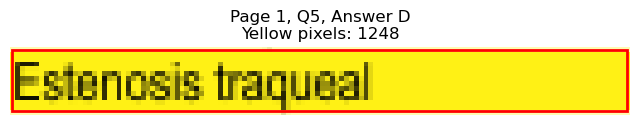


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=132.0, y1=442.9
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 333
Page 1, Q6, A: Yellow percentage: 0.0%


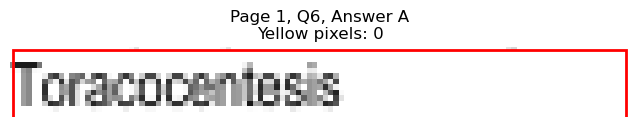

Page 1, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=138.5, y1=455.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 347
Page 1, Q6, B: Yellow percentage: 0.0%


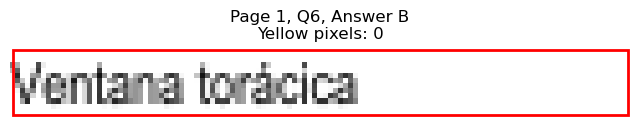

Page 1, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=405.3, y1=442.9
Page 1, Q6, C: Yellow pixels: 1357
Page 1, Q6, C: Total non-white pixels: 1677
Page 1, Q6, C: Yellow percentage: 80.9%


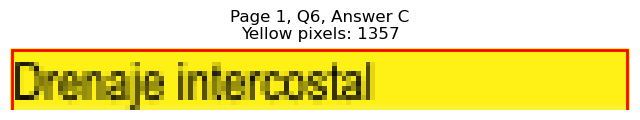

Page 1, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=430.4, y1=455.5
Page 1, Q6, D: Yellow pixels: 152
Page 1, Q6, D: Total non-white pixels: 678
Page 1, Q6, D: Yellow percentage: 22.4%


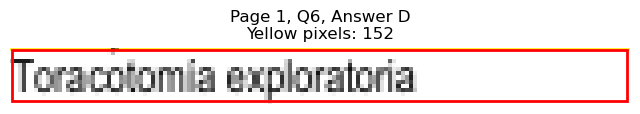


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=137.5, y1=493.4
Page 1, Q7, A: Yellow pixels: 1160
Page 1, Q7, A: Total non-white pixels: 1680
Page 1, Q7, A: Yellow percentage: 69.0%


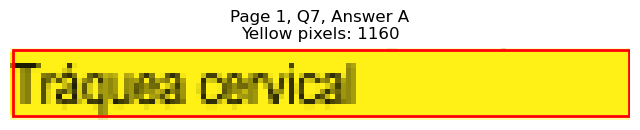

Page 1, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=160.6, y1=506.0
Page 1, Q7, B: Yellow pixels: 1
Page 1, Q7, B: Total non-white pixels: 532
Page 1, Q7, B: Yellow percentage: 0.2%


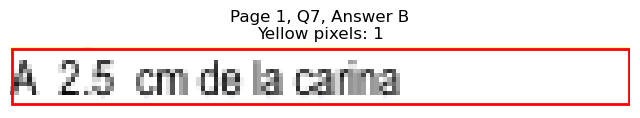

Page 1, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=521.3, y1=493.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 869
Page 1, Q7, C: Yellow percentage: 0.0%


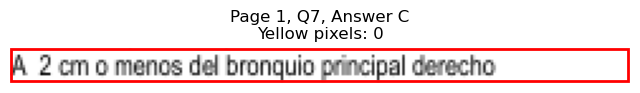

Page 1, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=400.4, y1=506.0
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 353
Page 1, Q7, D: Yellow percentage: 0.0%


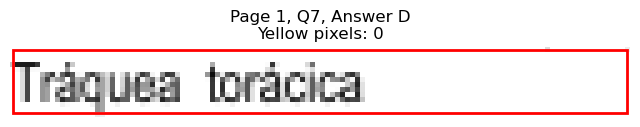


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=282.4, y1=543.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1111
Page 1, Q8, A: Yellow percentage: 0.0%


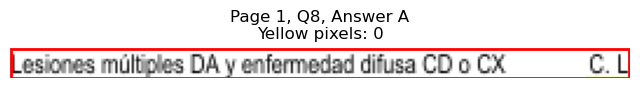

Page 1, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=240.9, y1=556.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 871
Page 1, Q8, B: Yellow percentage: 0.0%


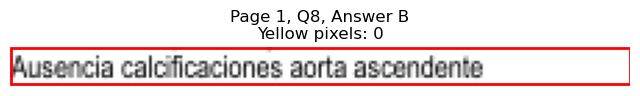

Page 1, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=488.6, y1=543.8
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 986
Page 1, Q8, C: Yellow percentage: 0.0%


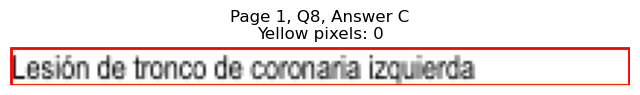

Page 1, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=503.7, y1=556.4
Page 1, Q8, D: Yellow pixels: 2083
Page 1, Q8, D: Total non-white pixels: 2996
Page 1, Q8, D: Yellow percentage: 69.5%


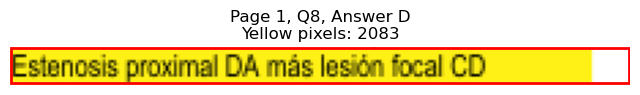


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=123.0, y1=594.4
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 264
Page 1, Q9, A: Yellow percentage: 0.0%


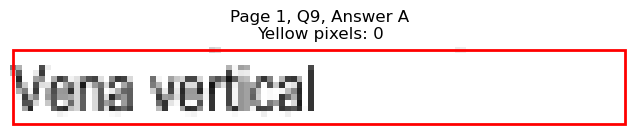

Page 1, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=175.6, y1=607.0
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 515
Page 1, Q9, B: Yellow percentage: 0.0%


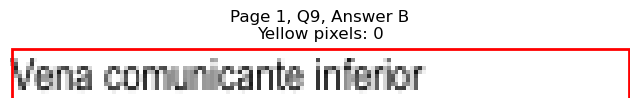

Page 1, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=396.8, y1=594.4
Page 1, Q9, C: Yellow pixels: 120
Page 1, Q9, C: Total non-white pixels: 467
Page 1, Q9, C: Yellow percentage: 25.7%


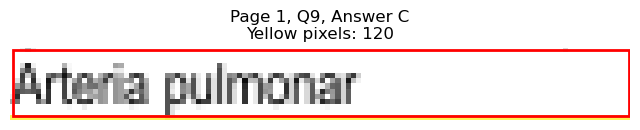

Page 1, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=391.3, y1=607.0
Page 1, Q9, D: Yellow pixels: 1278
Page 1, Q9, D: Total non-white pixels: 1495
Page 1, Q9, D: Yellow percentage: 85.5%


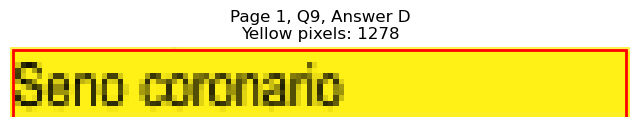


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=82.8, y1=644.9
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 74
Page 1, Q10, A: Yellow percentage: 0.0%


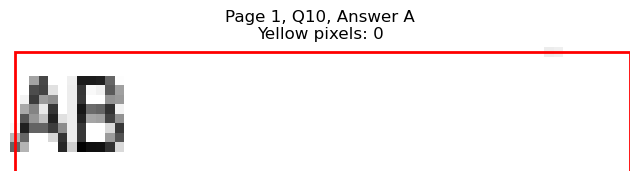

Page 1, Q10 - B: Detected box: x0=68.3, y0=493.4, x1=76.8, y1=506.0
Page 1, Q10, B: Yellow pixels: 1
Page 1, Q10, B: Total non-white pixels: 290
Page 1, Q10, B: Yellow percentage: 0.3%


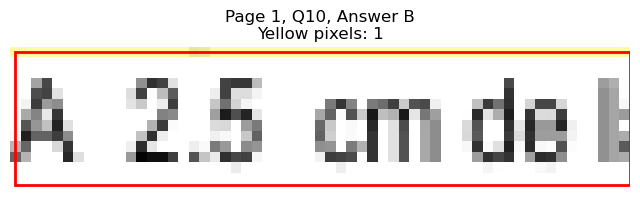

Page 1, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=341.1, y1=644.9
Page 1, Q10, C: Yellow pixels: 797
Page 1, Q10, C: Total non-white pixels: 845
Page 1, Q10, C: Yellow percentage: 94.3%


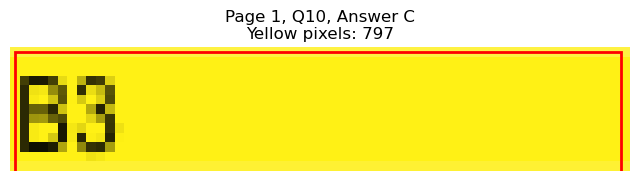

Page 1, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=341.1, y1=657.5
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 50
Page 1, Q10, D: Yellow percentage: 0.0%


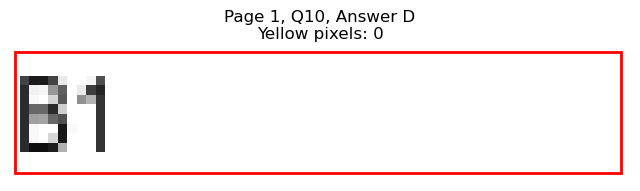


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=169.6, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 493
Page 1, Q11, A: Yellow percentage: 0.0%


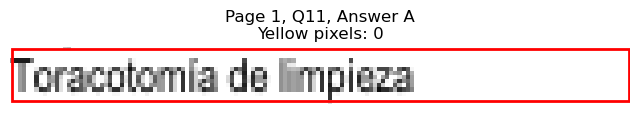

Page 1, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=181.1, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 544
Page 1, Q11, B: Yellow percentage: 0.0%


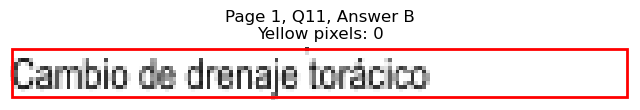

Page 1, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=432.9, y1=708.0
Page 1, Q11, C: Yellow pixels: 156
Page 1, Q11, C: Total non-white pixels: 879
Page 1, Q11, C: Yellow percentage: 17.7%


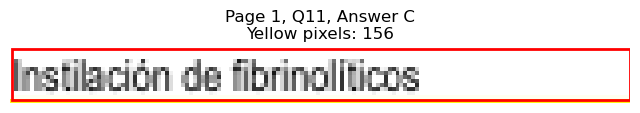

Page 1, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=439.4, y1=720.6
Page 1, Q11, D: Yellow pixels: 1682
Page 1, Q11, D: Total non-white pixels: 2282
Page 1, Q11, D: Yellow percentage: 73.7%


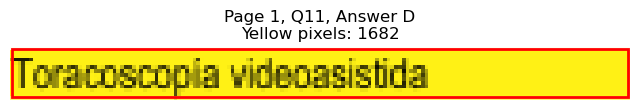


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=160.6, y1=114.7
Page 2, Q1, A: Yellow pixels: 4
Page 2, Q1, A: Total non-white pixels: 630
Page 2, Q1, A: Yellow percentage: 0.6%


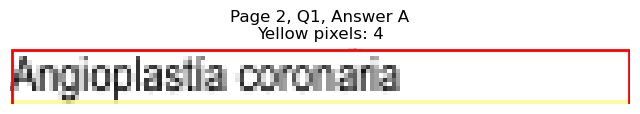

Page 2, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=159.0, y1=127.3
Page 2, Q1, B: Yellow pixels: 1322
Page 2, Q1, B: Total non-white pixels: 1988
Page 2, Q1, B: Yellow percentage: 66.5%


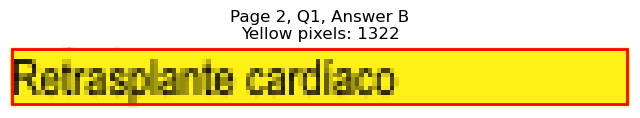

Page 2, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=422.8, y1=114.7
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 454
Page 2, Q1, C: Yellow percentage: 0.0%


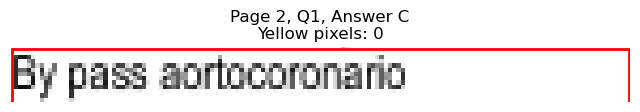

Page 2, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=433.4, y1=127.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 555
Page 2, Q1, D: Yellow percentage: 0.0%


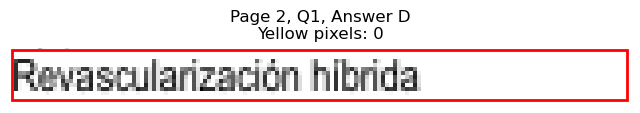


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=187.1, y1=190.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 576
Page 2, Q2, A: Yellow percentage: 0.0%


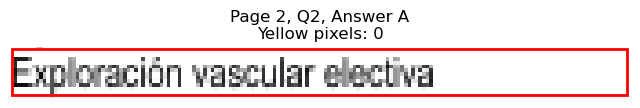

Page 2, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=120.5, y1=203.0
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 283
Page 2, Q2, B: Yellow percentage: 0.0%


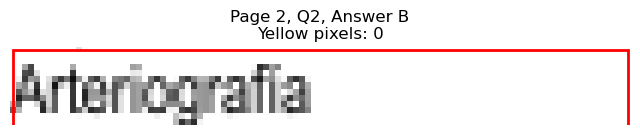

Page 2, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=475.5, y1=190.4
Page 2, Q2, C: Yellow pixels: 1825
Page 2, Q2, C: Total non-white pixels: 2786
Page 2, Q2, C: Yellow percentage: 65.5%


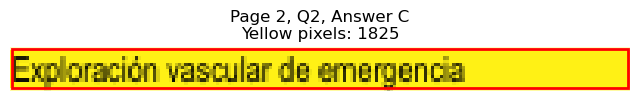

Page 2, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=368.2, y1=203.0
Page 2, Q2, D: Yellow pixels: 1
Page 2, Q2, D: Total non-white pixels: 289
Page 2, Q2, D: Yellow percentage: 0.3%


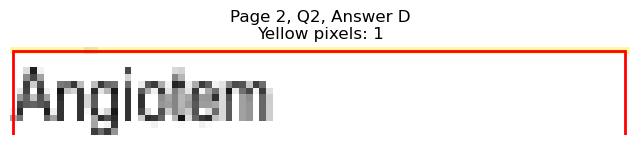


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=132.0, y1=266.1
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 330
Page 2, Q3, A: Yellow percentage: 0.0%


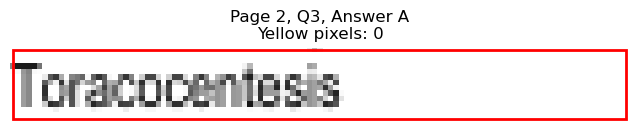

Page 2, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=171.1, y1=278.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 527
Page 2, Q3, B: Yellow percentage: 0.0%


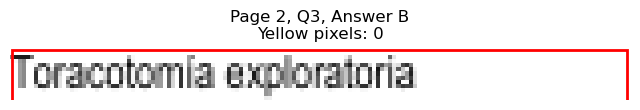

Page 2, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=405.3, y1=266.1
Page 2, Q3, C: Yellow pixels: 1357
Page 2, Q3, C: Total non-white pixels: 1806
Page 2, Q3, C: Yellow percentage: 75.1%


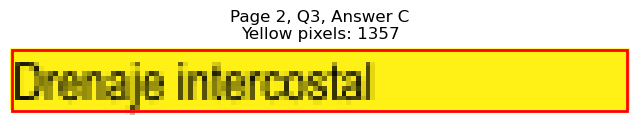

Page 2, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=387.2, y1=278.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 418
Page 2, Q3, D: Yellow percentage: 0.0%


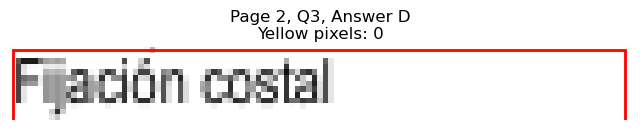


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=112.0, y1=316.7
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 214
Page 2, Q4, A: Yellow percentage: 0.0%


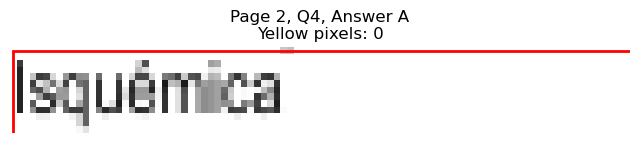

Page 2, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=161.5, y1=329.3
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 468
Page 2, Q4, B: Yellow percentage: 0.0%


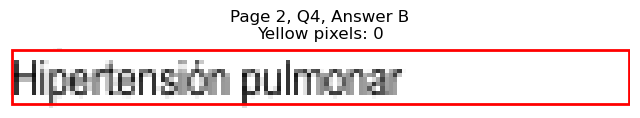

Page 2, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=393.8, y1=316.7
Page 2, Q4, C: Yellow pixels: 1255
Page 2, Q4, C: Total non-white pixels: 1521
Page 2, Q4, C: Yellow percentage: 82.5%


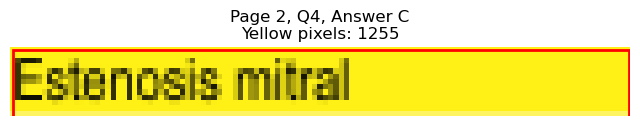

Page 2, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=426.3, y1=329.3
Page 2, Q4, D: Yellow pixels: 150
Page 2, Q4, D: Total non-white pixels: 677
Page 2, Q4, D: Yellow percentage: 22.2%


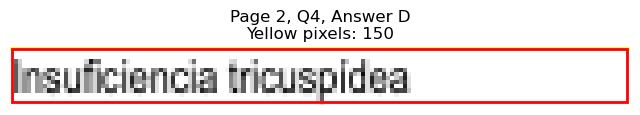


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=168.1, y1=405.0
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 663
Page 2, Q5, A: Yellow percentage: 0.0%


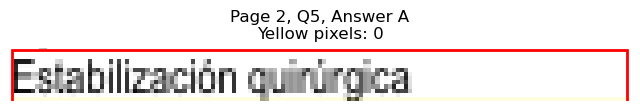

Page 2, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=136.5, y1=417.6
Page 2, Q5, B: Yellow pixels: 1280
Page 2, Q5, B: Total non-white pixels: 1666
Page 2, Q5, B: Yellow percentage: 76.8%


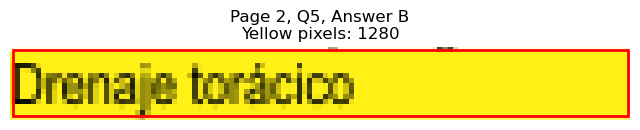

Page 2, Q5 - C: Detected box: x0=327.5, y0=556.5, x1=391.4, y1=569.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 573
Page 2, Q5, C: Yellow percentage: 0.0%


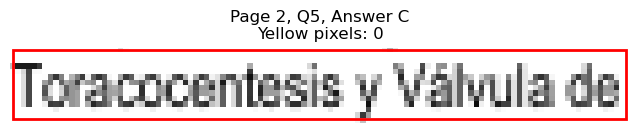

Page 2, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=386.7, y1=417.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 293
Page 2, Q5, D: Yellow percentage: 0.0%


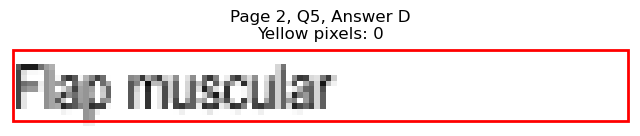


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=136.5, y1=455.5
Page 2, Q6, A: Yellow pixels: 119
Page 2, Q6, A: Total non-white pixels: 478
Page 2, Q6, A: Yellow percentage: 24.9%


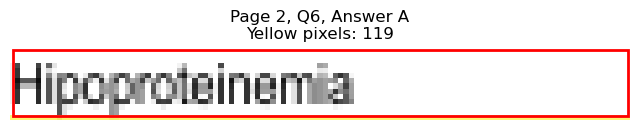

Page 2, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=143.5, y1=468.1
Page 2, Q6, B: Yellow pixels: 1292
Page 2, Q6, B: Total non-white pixels: 1764
Page 2, Q6, B: Yellow percentage: 73.2%


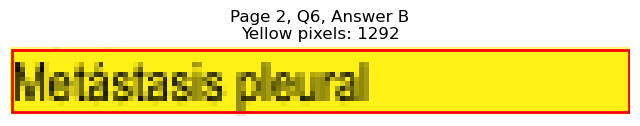

Page 2, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=438.4, y1=455.5
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 594
Page 2, Q6, C: Yellow percentage: 0.0%


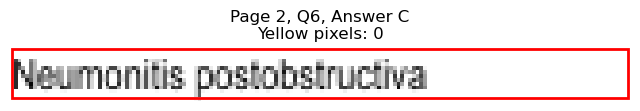

Page 2, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=402.8, y1=468.1
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 386
Page 2, Q6, D: Yellow percentage: 0.0%


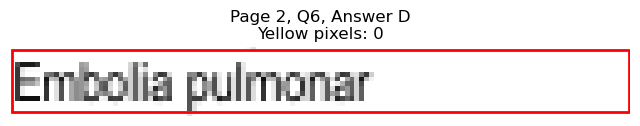


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=170.7, y1=506.0
Page 2, Q7, A: Yellow pixels: 1572
Page 2, Q7, A: Total non-white pixels: 1991
Page 2, Q7, A: Yellow percentage: 79.0%


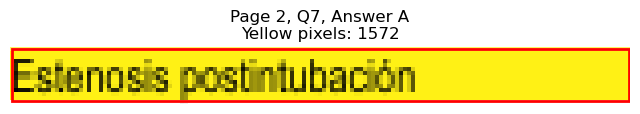

Page 2, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=193.7, y1=518.6
Page 2, Q7, B: Yellow pixels: 174
Page 2, Q7, B: Total non-white pixels: 849
Page 2, Q7, B: Yellow percentage: 20.5%


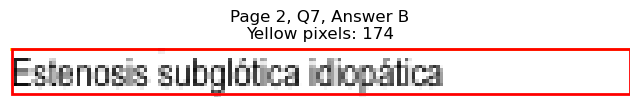

Page 2, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=444.9, y1=506.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 595
Page 2, Q7, C: Yellow percentage: 0.0%


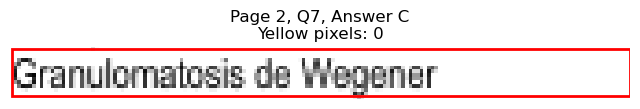

Page 2, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=446.9, y1=518.6
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 608
Page 2, Q7, D: Yellow percentage: 0.0%


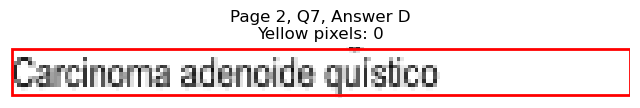


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=228.3, y1=569.2
Page 2, Q8, A: Yellow pixels: 211
Page 2, Q8, A: Total non-white pixels: 1005
Page 2, Q8, A: Yellow percentage: 21.0%


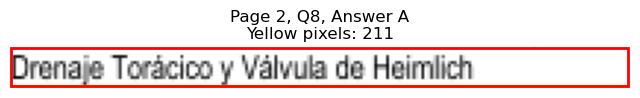

Page 2, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=255.3, y1=581.8
Page 2, Q8, B: Yellow pixels: 2076
Page 2, Q8, B: Total non-white pixels: 2782
Page 2, Q8, B: Yellow percentage: 74.6%


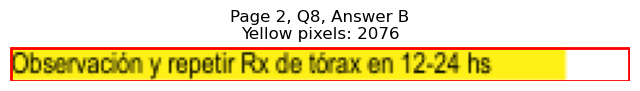

Page 2, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=480.0, y1=569.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 764
Page 2, Q8, C: Yellow percentage: 0.0%


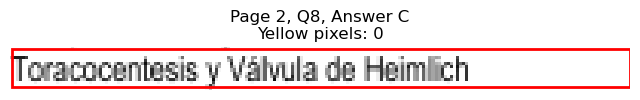

Page 2, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=464.0, y1=581.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 673
Page 2, Q8, D: Yellow percentage: 0.0%


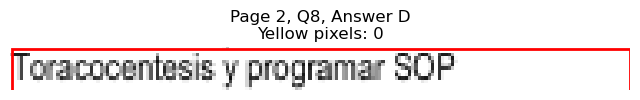


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=187.7, y1=632.3
Page 2, Q9, A: Yellow pixels: 1606
Page 2, Q9, A: Total non-white pixels: 2380
Page 2, Q9, A: Yellow percentage: 67.5%


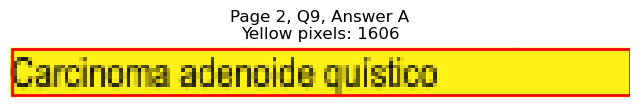

Page 2, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=166.6, y1=644.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 629
Page 2, Q9, B: Yellow percentage: 0.0%


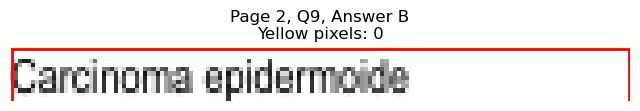

Page 2, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=366.3, y1=632.3
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 195
Page 2, Q9, C: Yellow percentage: 0.0%


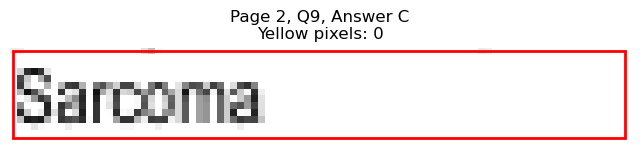

Page 2, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=383.7, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 274
Page 2, Q9, D: Yellow percentage: 0.0%


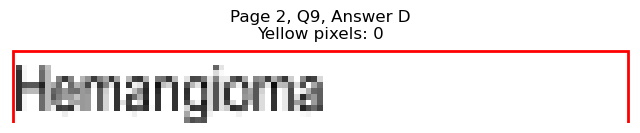


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=213.8, y1=682.7
Page 2, Q10, A: Yellow pixels: 1
Page 2, Q10, A: Total non-white pixels: 935
Page 2, Q10, A: Yellow percentage: 0.1%


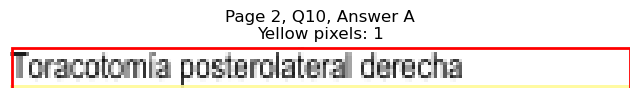

Page 2, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=217.7, y1=695.3
Page 2, Q10, B: Yellow pixels: 1788
Page 2, Q10, B: Total non-white pixels: 2800
Page 2, Q10, B: Yellow percentage: 63.9%


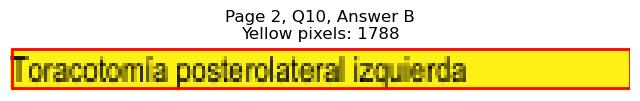

Page 2, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=410.9, y1=682.7
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 429
Page 2, Q10, C: Yellow percentage: 0.0%


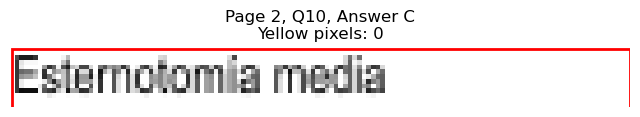

Page 2, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=404.8, y1=695.3
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 382
Page 2, Q10, D: Yellow percentage: 0.0%


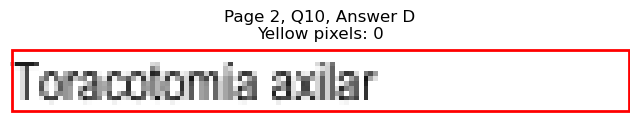


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=135.0, y1=733.2
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 326
Page 2, Q11, A: Yellow percentage: 0.0%


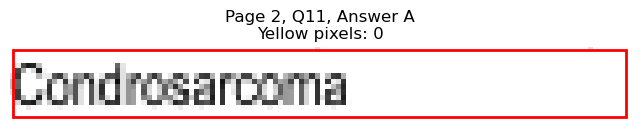

Page 2, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=126.0, y1=745.8
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 279
Page 2, Q11, B: Yellow percentage: 0.0%


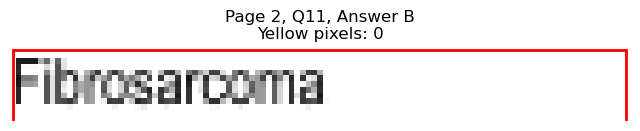

Page 2, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=381.7, y1=733.2
Page 2, Q11, C: Yellow pixels: 105
Page 2, Q11, C: Total non-white pixels: 349
Page 2, Q11, C: Yellow percentage: 30.1%


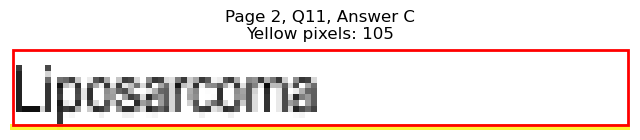

Page 2, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=396.3, y1=745.8
Page 2, Q11, D: Yellow pixels: 1306
Page 2, Q11, D: Total non-white pixels: 1560
Page 2, Q11, D: Yellow percentage: 83.7%


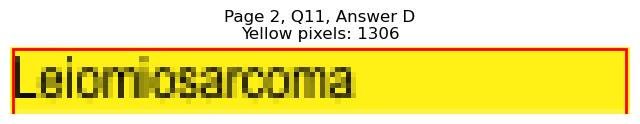


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 12 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=162.6, y1=102.1
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 452
Page 3, Q1, A: Yellow percentage: 0.0%


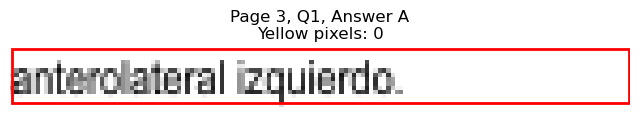

Page 3, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=157.1, y1=114.7
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 438
Page 3, Q1, B: Yellow percentage: 0.0%


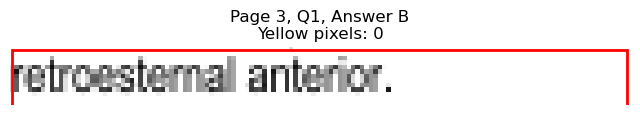

Page 3, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=426.3, y1=102.1
Page 3, Q1, C: Yellow pixels: 1547
Page 3, Q1, C: Total non-white pixels: 2100
Page 3, Q1, C: Yellow percentage: 73.7%


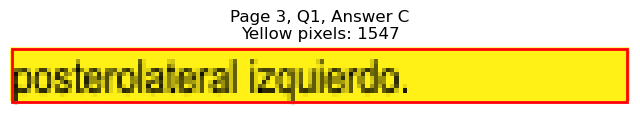

Page 3, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=389.2, y1=114.7
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 419
Page 3, Q1, D: Yellow percentage: 0.0%


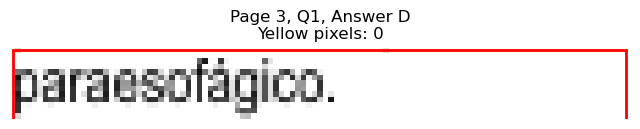


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=115.0, y1=165.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 237
Page 3, Q2, A: Yellow percentage: 0.0%


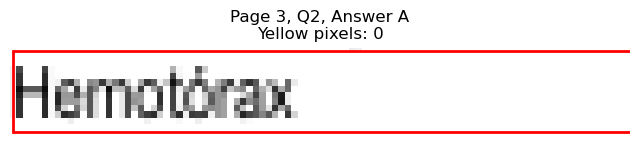

Page 3, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=140.1, y1=177.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 374
Page 3, Q2, B: Yellow percentage: 0.0%


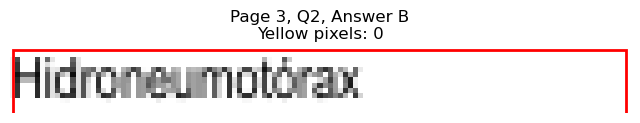

Page 3, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=423.8, y1=165.2
Page 3, Q2, C: Yellow pixels: 147
Page 3, Q2, C: Total non-white pixels: 628
Page 3, Q2, C: Yellow percentage: 23.4%


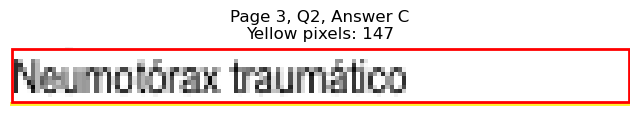

Page 3, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=425.3, y1=177.8
Page 3, Q2, D: Yellow pixels: 1536
Page 3, Q2, D: Total non-white pixels: 1937
Page 3, Q2, D: Yellow percentage: 79.3%


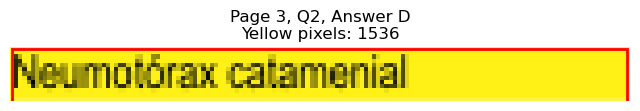


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=92.4, y1=215.6
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 116
Page 3, Q3, A: Yellow percentage: 0.0%


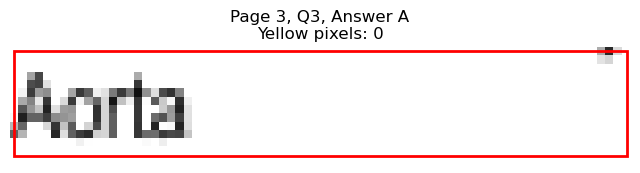

Page 3, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=115.1, y1=228.3
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 235
Page 3, Q3, B: Yellow percentage: 0.0%


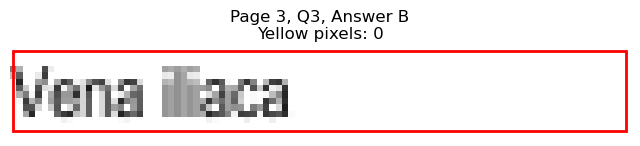

Page 3, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=402.8, y1=215.6
Page 3, Q3, C: Yellow pixels: 1368
Page 3, Q3, C: Total non-white pixels: 1764
Page 3, Q3, C: Yellow percentage: 77.6%


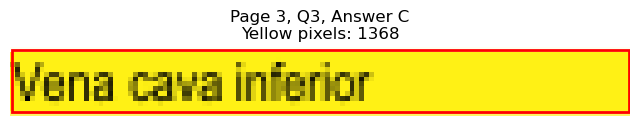

Page 3, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=379.7, y1=228.3
Page 3, Q3, D: Yellow pixels: 103
Page 3, Q3, D: Total non-white pixels: 370
Page 3, Q3, D: Yellow percentage: 27.8%


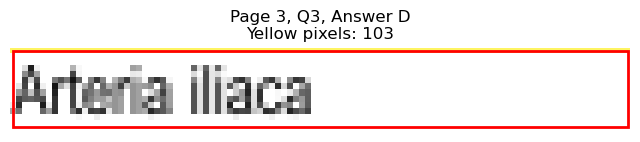


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=147.0, y1=266.1
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 360
Page 3, Q4, A: Yellow percentage: 0.0%


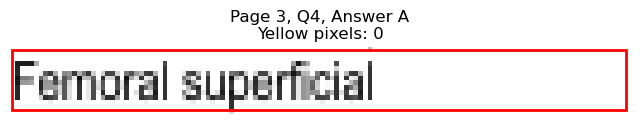

Page 3, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=151.1, y1=278.7
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 384
Page 3, Q4, B: Yellow percentage: 0.0%


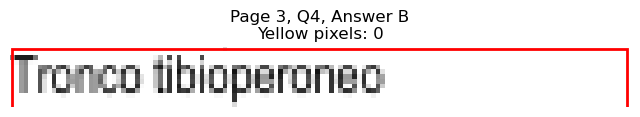

Page 3, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=401.2, y1=266.1
Page 3, Q4, C: Yellow pixels: 125
Page 3, Q4, C: Total non-white pixels: 486
Page 3, Q4, C: Yellow percentage: 25.7%


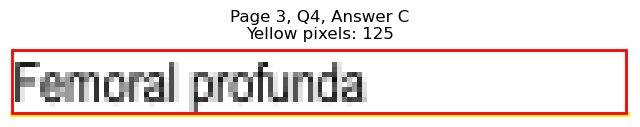

Page 3, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=363.2, y1=278.7
Page 3, Q4, D: Yellow pixels: 997
Page 3, Q4, D: Total non-white pixels: 1131
Page 3, Q4, D: Yellow percentage: 88.2%


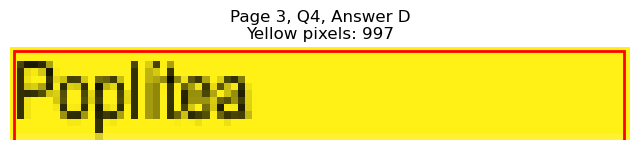


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=78.4, y1=341.9
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 32
Page 3, Q5, A: Yellow percentage: 0.0%


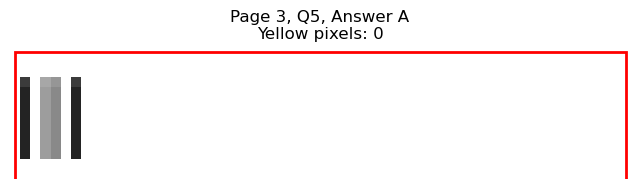

Page 3, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=79.3, y1=354.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 36
Page 3, Q5, B: Yellow percentage: 0.0%


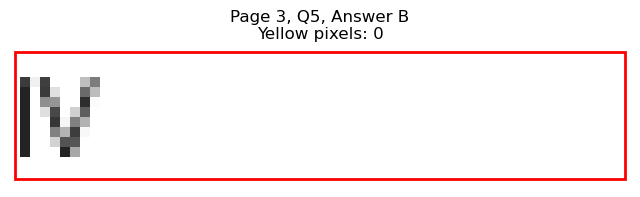

Page 3, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=324.4, y1=341.9
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 52
Page 3, Q5, C: Yellow percentage: 0.0%


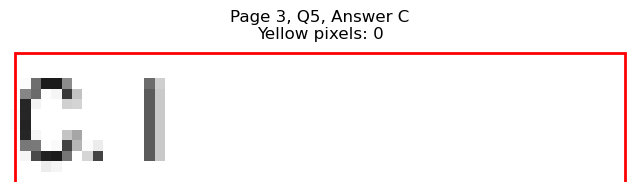

Page 3, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=324.4, y1=354.6
Page 3, Q5, D: Yellow pixels: 726
Page 3, Q5, D: Total non-white pixels: 840
Page 3, Q5, D: Yellow percentage: 86.4%


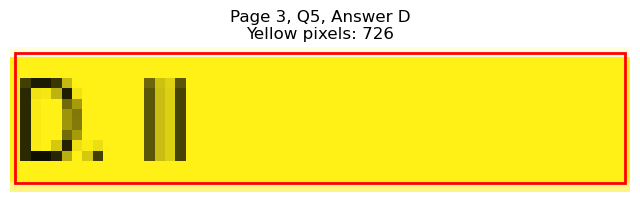


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=103.3, y1=392.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 162
Page 3, Q6, A: Yellow percentage: 0.0%


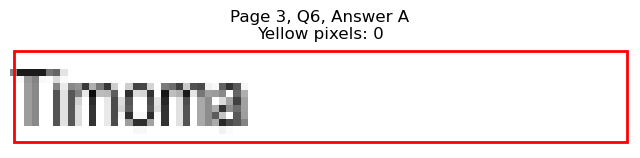

Page 3, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=109.5, y1=405.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 200
Page 3, Q6, B: Yellow percentage: 0.0%


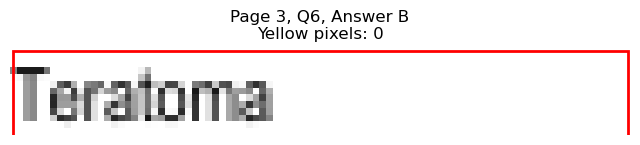

Page 3, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=408.3, y1=392.4
Page 3, Q6, C: Yellow pixels: 1265
Page 3, Q6, C: Total non-white pixels: 1848
Page 3, Q6, C: Yellow percentage: 68.5%


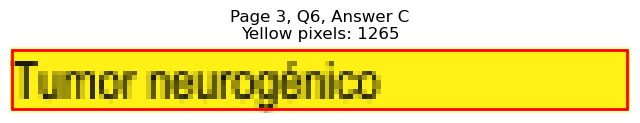

Page 3, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=362.1, y1=405.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 232
Page 3, Q6, D: Yellow percentage: 0.0%


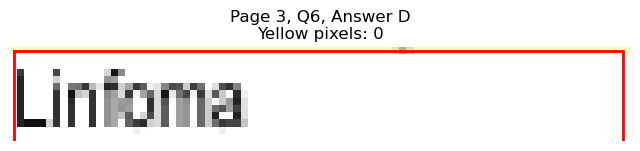


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=151.1, y1=442.9
Page 3, Q7, A: Yellow pixels: 1429
Page 3, Q7, A: Total non-white pixels: 1742
Page 3, Q7, A: Yellow percentage: 82.0%


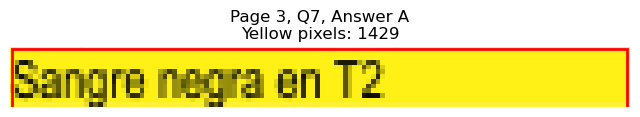

Page 3, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=151.1, y1=455.5
Page 3, Q7, B: Yellow pixels: 126
Page 3, Q7, B: Total non-white pixels: 528
Page 3, Q7, B: Yellow percentage: 23.9%


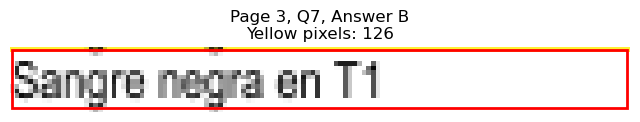

Page 3, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=383.7, y1=442.9
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 284
Page 3, Q7, C: Yellow percentage: 0.0%


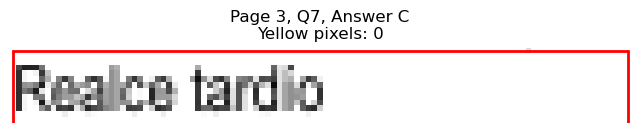

Page 3, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=418.4, y1=455.5
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 476
Page 3, Q7, D: Yellow percentage: 0.0%


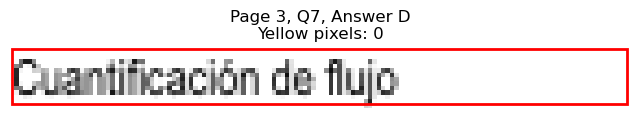


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=493.4, x1=220.4, y1=506.0
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 778
Page 3, Q8, A: Yellow percentage: 0.0%


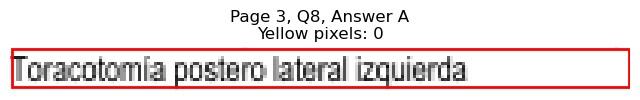

Page 3, Q8 - B: Detected box: x0=68.3, y0=506.0, x1=151.6, y1=518.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 428
Page 3, Q8, B: Yellow percentage: 0.0%


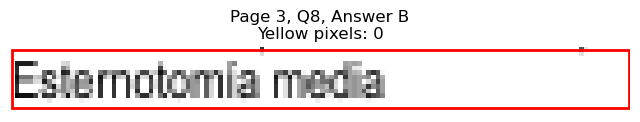

Page 3, Q8 - C: Detected box: x0=327.5, y0=493.4, x1=446.3, y1=506.0
Page 3, Q8, C: Yellow pixels: 170
Page 3, Q8, C: Total non-white pixels: 924
Page 3, Q8, C: Yellow percentage: 18.4%


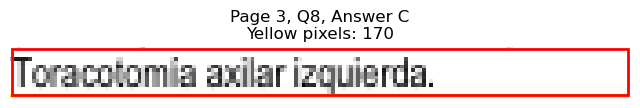

Page 3, Q8 - D: Detected box: x0=327.5, y0=506.0, x1=475.5, y1=518.6
Page 3, Q8, D: Yellow pixels: 1995
Page 3, Q8, D: Total non-white pixels: 2786
Page 3, Q8, D: Yellow percentage: 71.6%


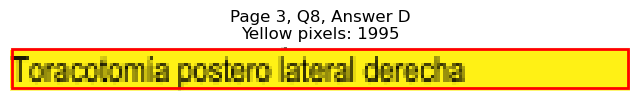


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=130.6, y1=569.2
Page 3, Q9, A: Yellow pixels: 1219
Page 3, Q9, A: Total non-white pixels: 1582
Page 3, Q9, A: Yellow percentage: 77.1%


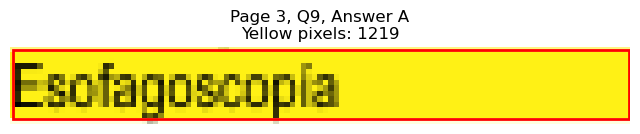

Page 3, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=127.0, y1=581.8
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 425
Page 3, Q9, B: Yellow percentage: 0.0%


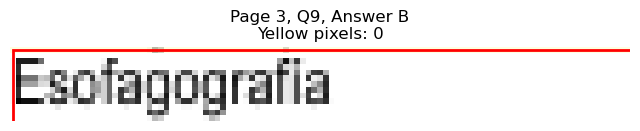

Page 3, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=389.2, y1=569.2
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 294
Page 3, Q9, C: Yellow percentage: 0.0%


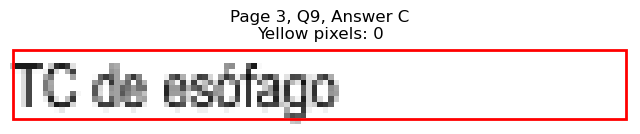

Page 3, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=368.7, y1=581.8
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 222
Page 3, Q9, D: Yellow percentage: 0.0%


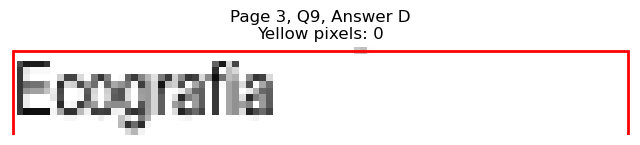


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=196.7, y1=619.6
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 661
Page 3, Q10, A: Yellow percentage: 0.0%


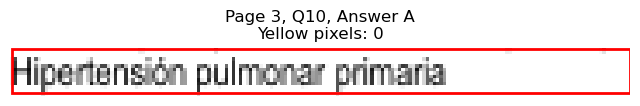

Page 3, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=237.8, y1=632.3
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 845
Page 3, Q10, B: Yellow percentage: 0.0%


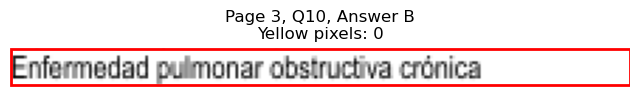

Page 3, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=389.7, y1=619.6
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 318
Page 3, Q10, C: Yellow percentage: 0.0%


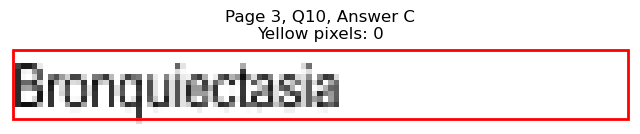

Page 3, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=442.4, y1=632.3
Page 3, Q10, D: Yellow pixels: 1549
Page 3, Q10, D: Total non-white pixels: 2324
Page 3, Q10, D: Yellow percentage: 66.7%


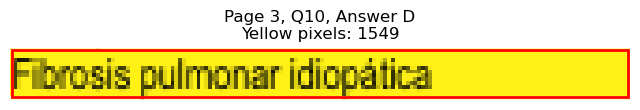


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=670.1, x1=167.7, y1=682.7
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 528
Page 3, Q11, A: Yellow percentage: 0.0%


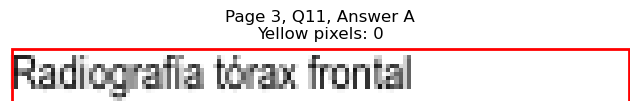

Page 3, Q11 - B: Detected box: x0=68.3, y0=682.7, x1=197.7, y1=695.3
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 662
Page 3, Q11, B: Yellow percentage: 0.0%


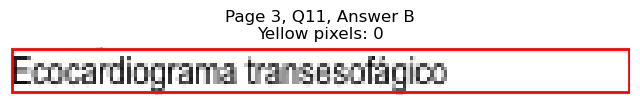

Page 3, Q11 - C: Detected box: x0=327.5, y0=670.1, x1=483.0, y1=682.7
Page 3, Q11, C: Yellow pixels: 2087
Page 3, Q11, C: Total non-white pixels: 2678
Page 3, Q11, C: Yellow percentage: 77.9%


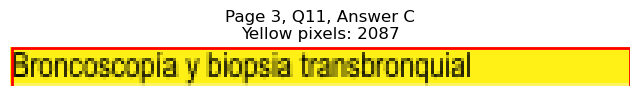

Page 3, Q11 - D: Detected box: x0=327.5, y0=682.7, x1=411.3, y1=695.3
Page 3, Q11, D: Yellow pixels: 134
Page 3, Q11, D: Total non-white pixels: 538
Page 3, Q11, D: Yellow percentage: 24.9%


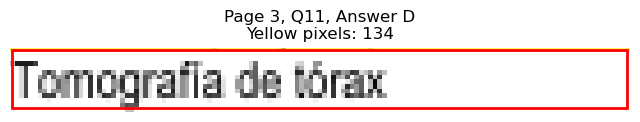


Page 3, Q11 - Selected Answer: C (based on yellow pixel count)




Page 3, Q12 - A: Detected box: x0=68.3, y0=720.6, x1=178.6, y1=733.2
Page 3, Q12, A: Yellow pixels: 161
Page 3, Q12, A: Total non-white pixels: 727
Page 3, Q12, A: Yellow percentage: 22.1%


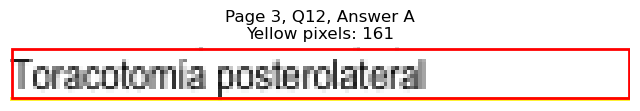

Page 3, Q12 - B: Detected box: x0=68.3, y0=506.0, x1=151.6, y1=518.6
Page 3, Q12, B: Yellow pixels: 0
Page 3, Q12, B: Total non-white pixels: 428
Page 3, Q12, B: Yellow percentage: 0.0%


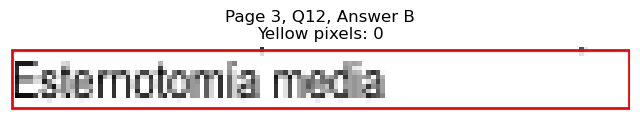

Page 3, Q12 - C: Detected box: x0=327.5, y0=720.6, x1=404.8, y1=733.2
Page 3, Q12, C: Yellow pixels: 0
Page 3, Q12, C: Total non-white pixels: 385
Page 3, Q12, C: Yellow percentage: 0.0%


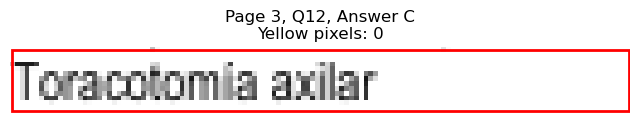

Page 3, Q12 - D: Detected box: x0=327.5, y0=733.2, x1=433.4, y1=745.8
Page 3, Q12, D: Yellow pixels: 0
Page 3, Q12, D: Total non-white pixels: 547
Page 3, Q12, D: Yellow percentage: 0.0%


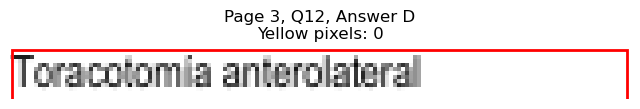


Page 3, Q12 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=93.9, y1=114.7
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 119
Page 4, Q1, A: Yellow percentage: 0.0%


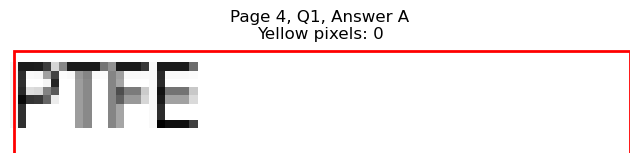

Page 4, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=190.7, y1=127.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 608
Page 4, Q1, B: Yellow percentage: 0.0%


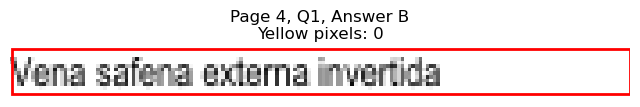

Page 4, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=447.4, y1=114.7
Page 4, Q1, C: Yellow pixels: 1784
Page 4, Q1, C: Total non-white pixels: 2223
Page 4, Q1, C: Yellow percentage: 80.3%


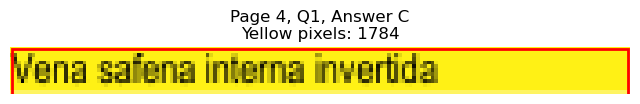

Page 4, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=384.2, y1=127.3
Page 4, Q1, D: Yellow pixels: 108
Page 4, Q1, D: Total non-white pixels: 391
Page 4, Q1, D: Yellow percentage: 27.6%


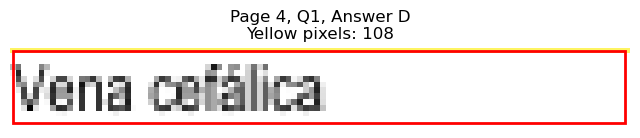


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=140.5, y1=165.2
Page 4, Q2, A: Yellow pixels: 123
Page 4, Q2, A: Total non-white pixels: 476
Page 4, Q2, A: Yellow percentage: 25.8%


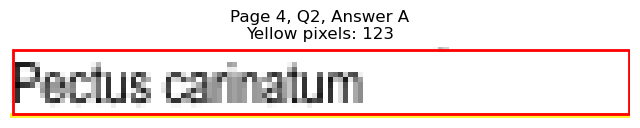

Page 4, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=144.5, y1=177.8
Page 4, Q2, B: Yellow pixels: 1372
Page 4, Q2, B: Total non-white pixels: 1651
Page 4, Q2, B: Yellow percentage: 83.1%


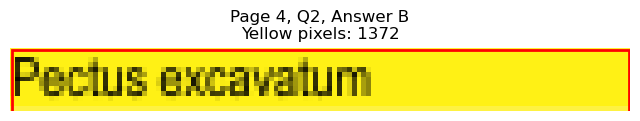

Page 4, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=412.3, y1=165.2
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 430
Page 4, Q2, C: Yellow percentage: 0.0%


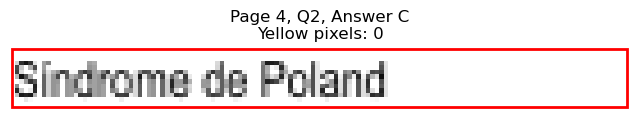

Page 4, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=400.7, y1=177.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 379
Page 4, Q2, D: Yellow percentage: 0.0%


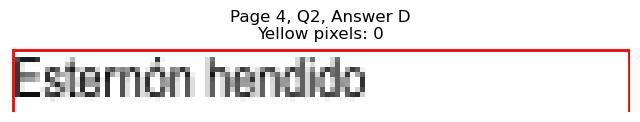


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=109.5, y1=215.6
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 237
Page 4, Q3, A: Yellow percentage: 0.0%


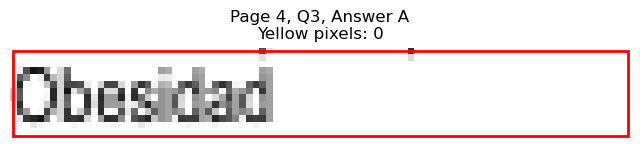

Page 4, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=134.5, y1=228.3
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 332
Page 4, Q3, B: Yellow percentage: 0.0%


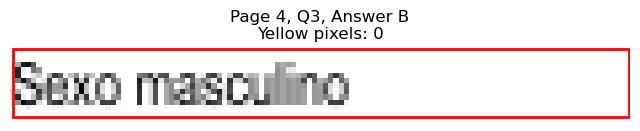

Page 4, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=379.7, y1=215.6
Page 4, Q3, C: Yellow pixels: 1129
Page 4, Q3, C: Total non-white pixels: 1442
Page 4, Q3, C: Yellow percentage: 78.3%


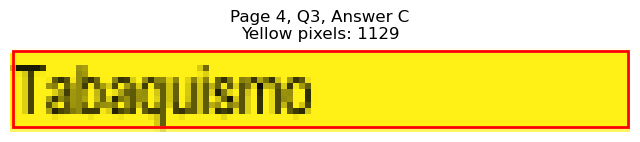

Page 4, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=392.8, y1=228.3
Page 4, Q3, D: Yellow pixels: 116
Page 4, Q3, D: Total non-white pixels: 430
Page 4, Q3, D: Yellow percentage: 27.0%


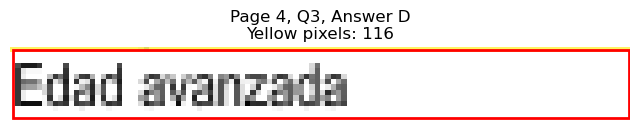


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=84.4, y1=266.1
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 59
Page 4, Q4, A: Yellow percentage: 0.0%


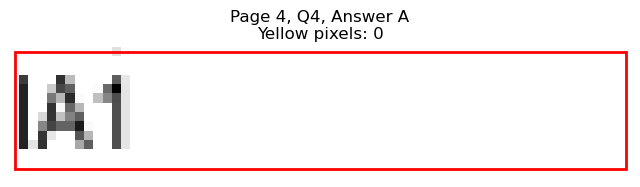

Page 4, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=84.4, y1=278.7
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 65
Page 4, Q4, B: Yellow percentage: 0.0%


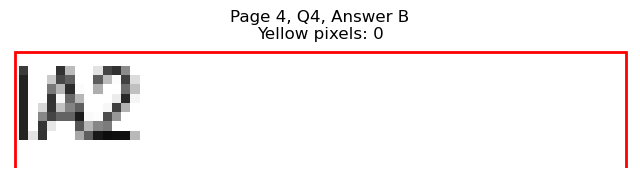

Page 4, Q4 - C: Detected box: x0=315.4, y0=253.5, x1=324.4, y1=266.1
Page 4, Q4, C: Yellow pixels: 734
Page 4, Q4, C: Total non-white pixels: 840
Page 4, Q4, C: Yellow percentage: 87.4%


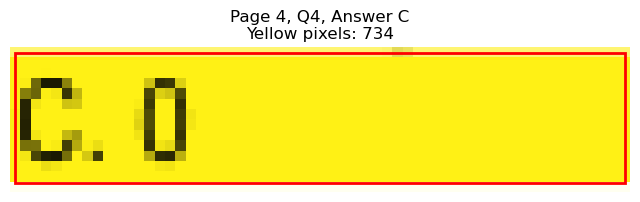

Page 4, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=343.6, y1=278.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 143
Page 4, Q4, D: Yellow percentage: 0.0%


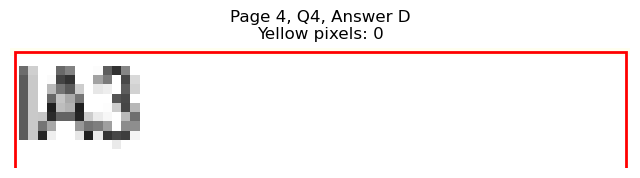


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=81.9, y1=329.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 66
Page 4, Q5, A: Yellow percentage: 0.0%


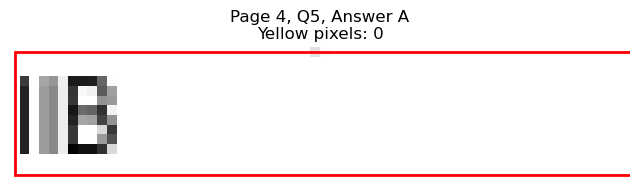

Page 4, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=84.4, y1=341.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 70
Page 4, Q5, B: Yellow percentage: 0.0%


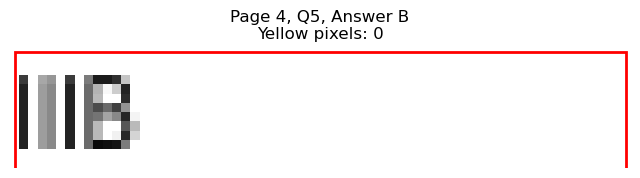

Page 4, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=341.1, y1=329.3
Page 4, Q5, C: Yellow pixels: 65
Page 4, Q5, C: Total non-white pixels: 128
Page 4, Q5, C: Yellow percentage: 50.8%


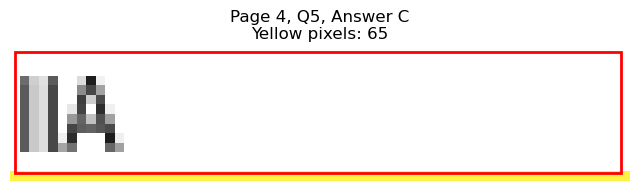

Page 4, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=343.6, y1=341.9
Page 4, Q5, D: Yellow pixels: 803
Page 4, Q5, D: Total non-white pixels: 871
Page 4, Q5, D: Yellow percentage: 92.2%


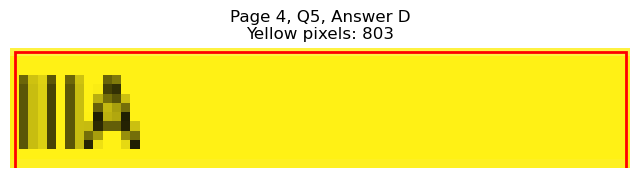


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=126.5, y1=379.8
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 418
Page 4, Q6, A: Yellow percentage: 0.0%


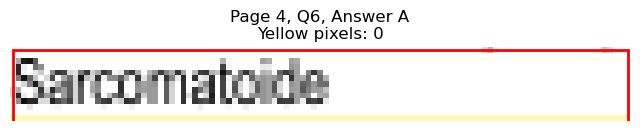

Page 4, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=102.4, y1=392.4
Page 4, Q6, B: Yellow pixels: 855
Page 4, Q6, B: Total non-white pixels: 1190
Page 4, Q6, B: Yellow percentage: 71.8%


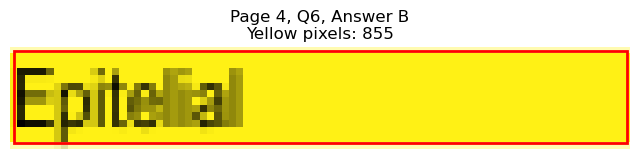

Page 4, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=351.7, y1=379.8
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 127
Page 4, Q6, C: Yellow percentage: 0.0%


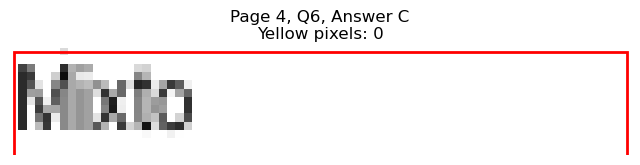

Page 4, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=368.7, y1=392.4
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 207
Page 4, Q6, D: Yellow percentage: 0.0%


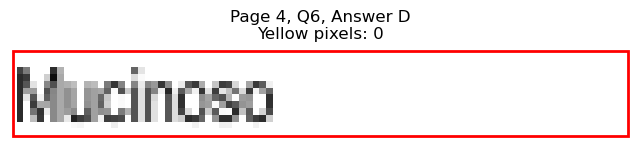


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=169.1, y1=442.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 506
Page 4, Q7, A: Yellow percentage: 0.0%


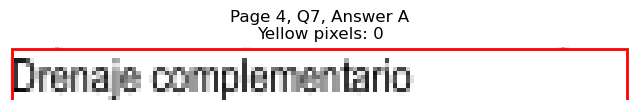

Page 4, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=150.0, y1=455.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 389
Page 4, Q7, B: Yellow percentage: 0.0%


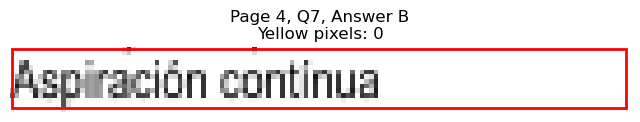

Page 4, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=440.3, y1=442.9
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 711
Page 4, Q7, C: Yellow percentage: 0.0%


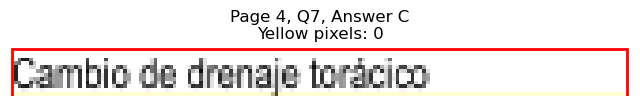

Page 4, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=430.9, y1=455.5
Page 4, Q7, D: Yellow pixels: 1580
Page 4, Q7, D: Total non-white pixels: 2156
Page 4, Q7, D: Yellow percentage: 73.3%


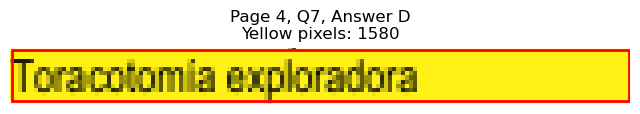


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=506.0, x1=136.5, y1=518.6
Page 4, Q8, A: Yellow pixels: 1280
Page 4, Q8, A: Total non-white pixels: 1666
Page 4, Q8, A: Yellow percentage: 76.8%


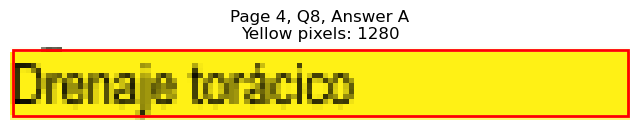

Page 4, Q8 - B: Detected box: x0=68.3, y0=518.6, x1=138.5, y1=531.2
Page 4, Q8, B: Yellow pixels: 120
Page 4, Q8, B: Total non-white pixels: 468
Page 4, Q8, B: Yellow percentage: 25.6%


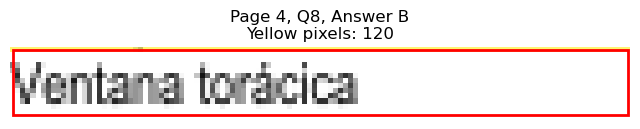

Page 4, Q8 - C: Detected box: x0=327.5, y0=506.0, x1=380.8, y1=518.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 264
Page 4, Q8, C: Yellow percentage: 0.0%


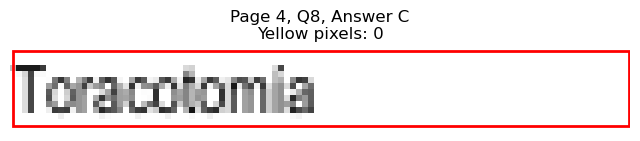

Page 4, Q8 - D: Detected box: x0=327.5, y0=518.6, x1=404.8, y1=531.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 396
Page 4, Q8, D: Yellow percentage: 0.0%


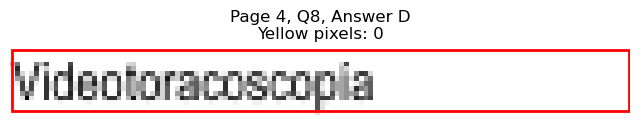


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=196.7, y1=569.2
Page 4, Q9, A: Yellow pixels: 1782
Page 4, Q9, A: Total non-white pixels: 2506
Page 4, Q9, A: Yellow percentage: 71.1%


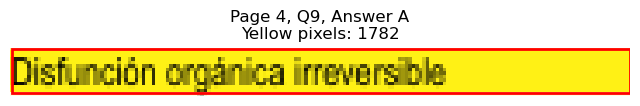

Page 4, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=161.5, y1=581.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 593
Page 4, Q9, B: Yellow percentage: 0.0%


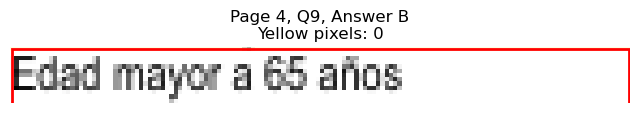

Page 4, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=433.4, y1=569.2
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 515
Page 4, Q9, C: Yellow percentage: 0.0%


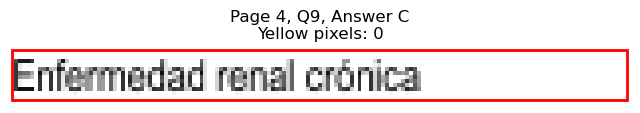

Page 4, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=414.8, y1=581.8
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 449
Page 4, Q9, D: Yellow percentage: 0.0%


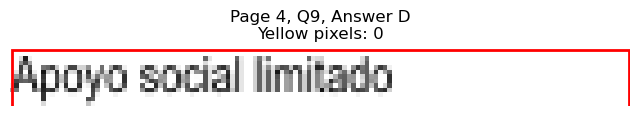


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=619.6, x1=291.5, y1=632.3
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 1130
Page 4, Q10, A: Yellow percentage: 0.0%


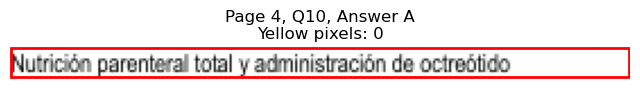

Page 4, Q10 - B: Detected box: x0=68.3, y0=632.2, x1=346.3, y1=644.9
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 1653
Page 4, Q10, B: Yellow percentage: 0.0%


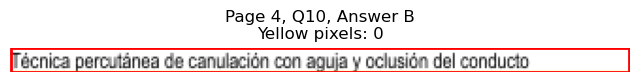

Page 4, Q10 - C: Detected box: x0=68.8, y0=644.9, x1=301.0, y1=657.5
Page 4, Q10, C: Yellow pixels: 2803
Page 4, Q10, C: Total non-white pixels: 3976
Page 4, Q10, C: Yellow percentage: 70.5%


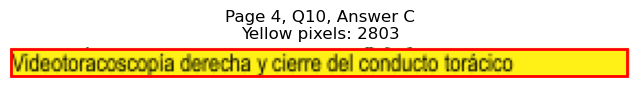

Page 4, Q10 - D: Detected box: x0=68.8, y0=657.5, x1=254.3, y1=670.1
Page 4, Q10, D: Yellow pixels: 236
Page 4, Q10, D: Total non-white pixels: 1187
Page 4, Q10, D: Yellow percentage: 19.9%


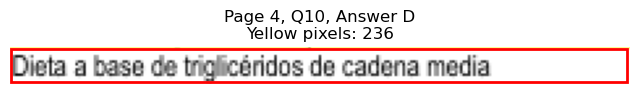


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=192.6, y1=708.0
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 574
Page 4, Q11, A: Yellow percentage: 0.0%


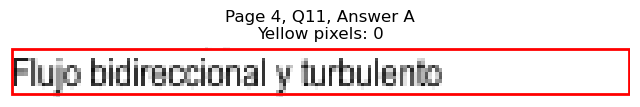

Page 4, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=202.7, y1=720.6
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 717
Page 4, Q11, B: Yellow percentage: 0.0%


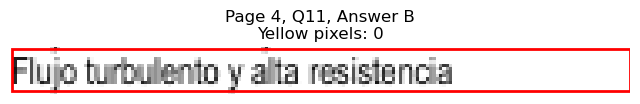

Page 4, Q11 - C: Detected box: x0=68.8, y0=720.6, x1=289.5, y1=733.2
Page 4, Q11, C: Yellow pixels: 272
Page 4, Q11, C: Total non-white pixels: 1342
Page 4, Q11, C: Yellow percentage: 20.3%


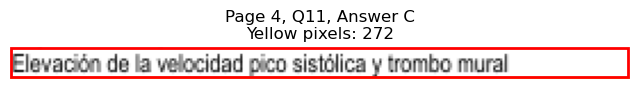

Page 4, Q11 - D: Detected box: x0=68.8, y0=733.2, x1=220.7, y1=745.8
Page 4, Q11, D: Yellow pixels: 2050
Page 4, Q11, D: Total non-white pixels: 2639
Page 4, Q11, D: Yellow percentage: 77.7%


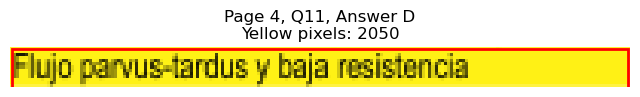


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 12 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=111.4, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 241
Page 5, Q1, A: Yellow percentage: 0.0%


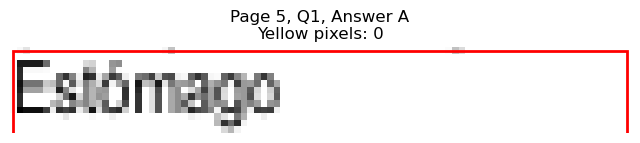

Page 5, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=100.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 153
Page 5, Q1, B: Yellow percentage: 0.0%


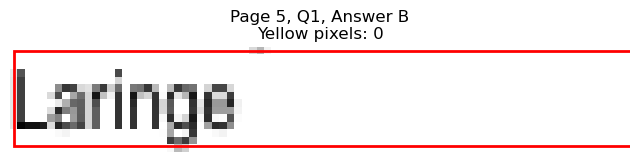

Page 5, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=363.7, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 268
Page 5, Q1, C: Yellow percentage: 0.0%


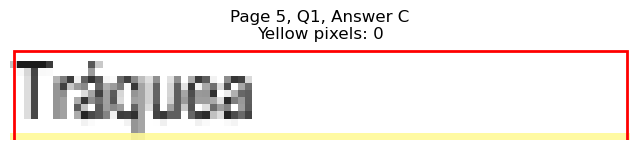

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=363.2, y1=127.3
Page 5, Q1, D: Yellow pixels: 907
Page 5, Q1, D: Total non-white pixels: 1218
Page 5, Q1, D: Yellow percentage: 74.5%


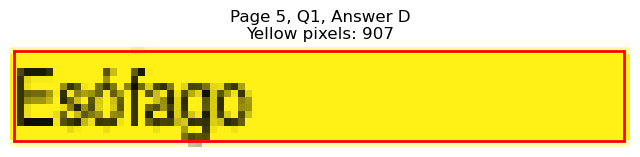


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=138.5, y1=165.2
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 356
Page 5, Q2, A: Yellow percentage: 0.0%


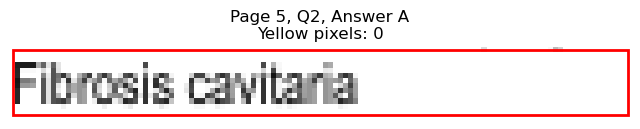

Page 5, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=175.6, y1=177.8
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 575
Page 5, Q2, B: Yellow percentage: 0.0%


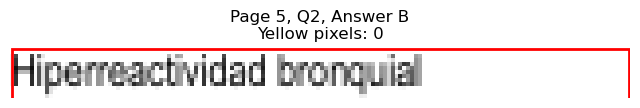

Page 5, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=449.5, y1=165.2
Page 5, Q2, C: Yellow pixels: 1775
Page 5, Q2, C: Total non-white pixels: 2422
Page 5, Q2, C: Yellow percentage: 73.3%


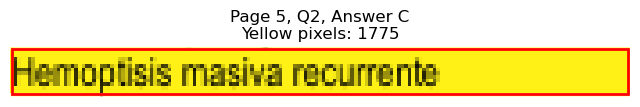

Page 5, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=421.4, y1=177.8
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 624
Page 5, Q2, D: Yellow percentage: 0.0%


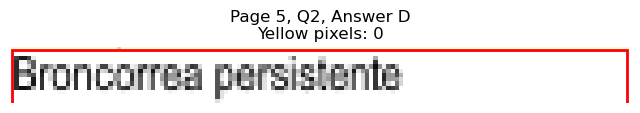


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=240.4, y1=228.3
Page 5, Q3, A: Yellow pixels: 1906
Page 5, Q3, A: Total non-white pixels: 2996
Page 5, Q3, A: Yellow percentage: 63.6%


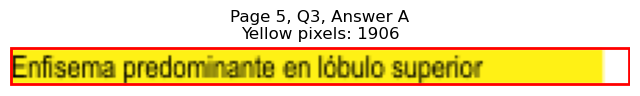

Page 5, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=196.0, y1=240.9
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 766
Page 5, Q3, B: Yellow percentage: 0.0%


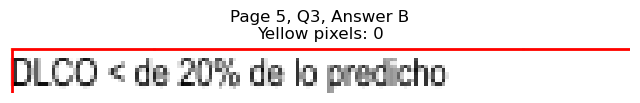

Page 5, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=440.1, y1=228.3
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 517
Page 5, Q3, C: Yellow percentage: 0.0%


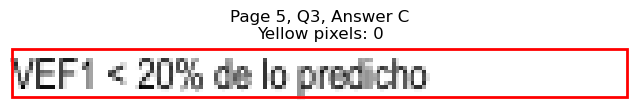

Page 5, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=394.3, y1=240.9
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 337
Page 5, Q3, D: Yellow percentage: 0.0%


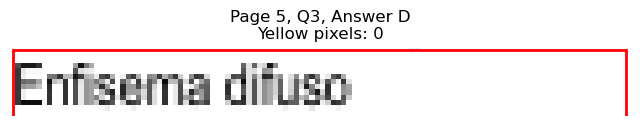


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=142.0, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 350
Page 5, Q4, A: Yellow percentage: 0.0%


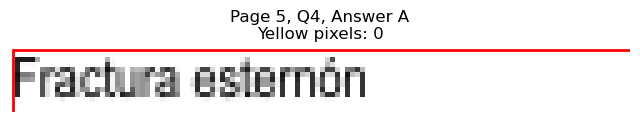

Page 5, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=151.6, y1=291.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 402
Page 5, Q4, B: Yellow percentage: 0.0%


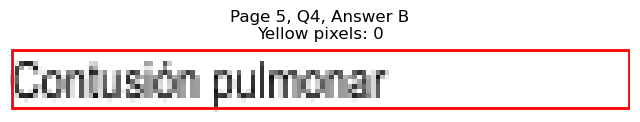

Page 5, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=379.1, y1=278.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 262
Page 5, Q4, C: Yellow percentage: 0.0%


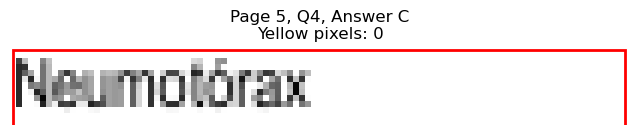

Page 5, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=389.7, y1=291.5
Page 5, Q4, D: Yellow pixels: 1215
Page 5, Q4, D: Total non-white pixels: 1582
Page 5, Q4, D: Yellow percentage: 76.8%


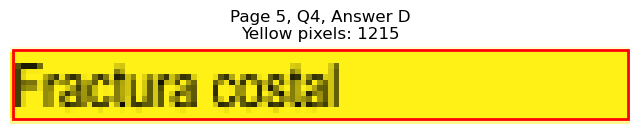


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=124.9, y1=329.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 278
Page 5, Q5, A: Yellow percentage: 0.0%


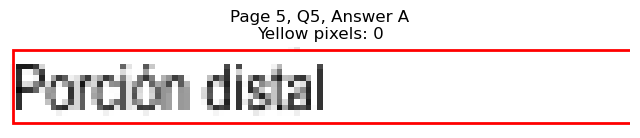

Page 5, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=160.6, y1=341.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 481
Page 5, Q5, B: Yellow percentage: 0.0%


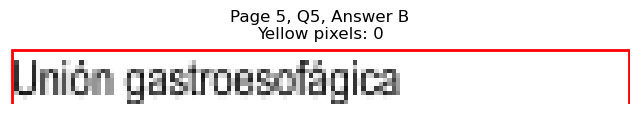

Page 5, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=449.5, y1=329.3
Page 5, Q5, C: Yellow pixels: 173
Page 5, Q5, C: Total non-white pixels: 830
Page 5, Q5, C: Yellow percentage: 20.8%


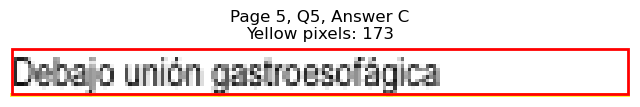

Page 5, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=431.3, y1=341.9
Page 5, Q5, D: Yellow pixels: 1641
Page 5, Q5, D: Total non-white pixels: 2015
Page 5, Q5, D: Yellow percentage: 81.4%


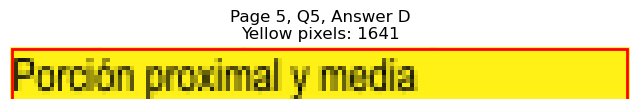


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=129.5, y1=379.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 432
Page 5, Q6, A: Yellow percentage: 0.0%


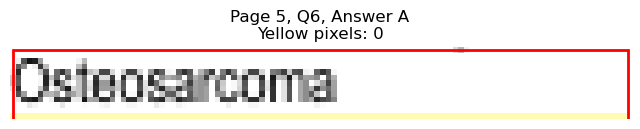

Page 5, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=135.0, y1=392.4
Page 5, Q6, B: Yellow pixels: 1176
Page 5, Q6, B: Total non-white pixels: 1652
Page 5, Q6, B: Yellow percentage: 71.2%


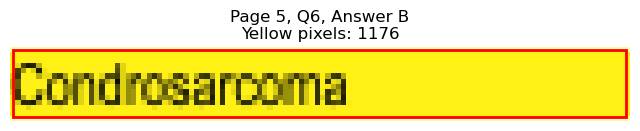

Page 5, Q6 - C: Detected box: x0=327.5, y0=367.1, x1=420.3, y1=379.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 464
Page 5, Q6, C: Yellow percentage: 0.0%


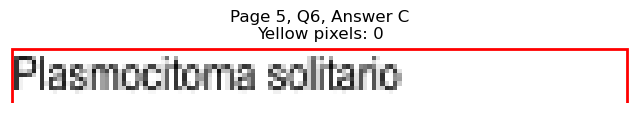

Page 5, Q6 - D: Detected box: x0=327.5, y0=379.7, x1=405.8, y1=392.4
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 389
Page 5, Q6, D: Yellow percentage: 0.0%


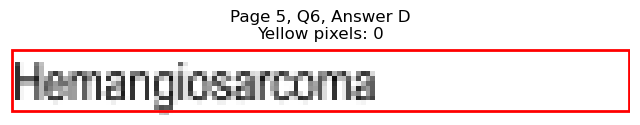


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=417.6, x1=168.1, y1=430.3
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 497
Page 5, Q7, A: Yellow percentage: 0.0%


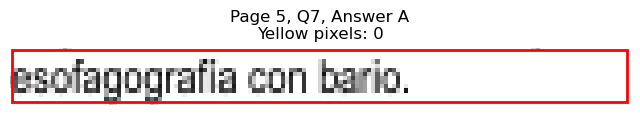

Page 5, Q7 - B: Detected box: x0=68.3, y0=430.2, x1=116.4, y1=442.9
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 231
Page 5, Q7, B: Yellow percentage: 0.0%


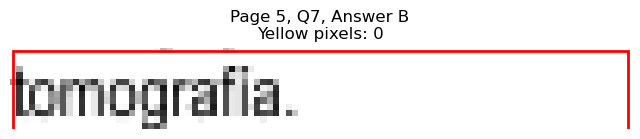

Page 5, Q7 - C: Detected box: x0=327.5, y0=417.6, x1=414.3, y1=430.3
Page 5, Q7, C: Yellow pixels: 1334
Page 5, Q7, C: Total non-white pixels: 1932
Page 5, Q7, C: Yellow percentage: 69.0%


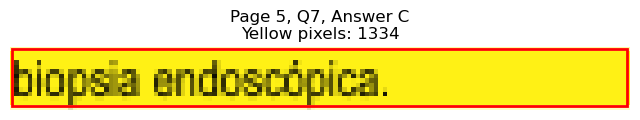

Page 5, Q7 - D: Detected box: x0=327.5, y0=430.2, x1=370.1, y1=442.9
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 308
Page 5, Q7, D: Yellow percentage: 0.0%


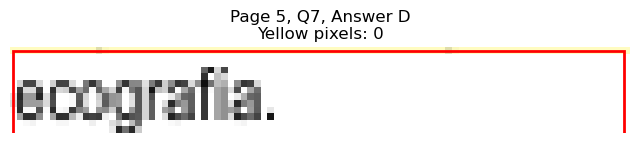


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=468.1, x1=137.1, y1=480.7
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 318
Page 5, Q8, A: Yellow percentage: 0.0%


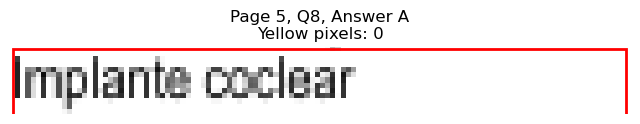

Page 5, Q8 - B: Detected box: x0=68.3, y0=480.8, x1=205.5, y1=493.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 680
Page 5, Q8, B: Yellow percentage: 0.0%


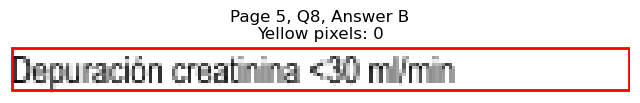

Page 5, Q8 - C: Detected box: x0=327.5, y0=468.1, x1=437.8, y1=480.7
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 545
Page 5, Q8, C: Yellow percentage: 0.0%


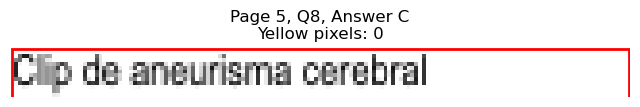

Page 5, Q8 - D: Detected box: x0=327.5, y0=480.8, x1=464.7, y1=493.4
Page 5, Q8, D: Yellow pixels: 1716
Page 5, Q8, D: Total non-white pixels: 2632
Page 5, Q8, D: Yellow percentage: 65.2%


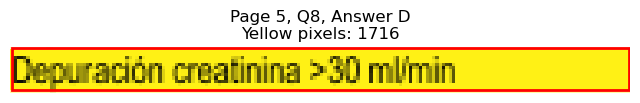


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=543.8, x1=161.1, y1=556.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 488
Page 5, Q9, A: Yellow percentage: 0.0%


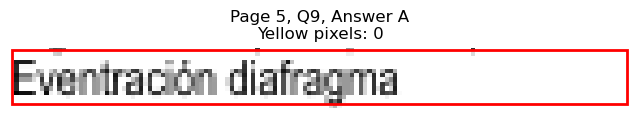

Page 5, Q9 - B: Detected box: x0=68.3, y0=556.5, x1=154.1, y1=569.2
Page 5, Q9, B: Yellow pixels: 1438
Page 5, Q9, B: Total non-white pixels: 1918
Page 5, Q9, B: Yellow percentage: 75.0%


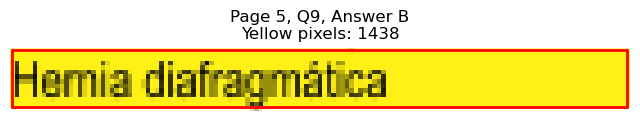

Page 5, Q9 - C: Detected box: x0=327.5, y0=543.8, x1=408.3, y1=556.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 407
Page 5, Q9, C: Yellow percentage: 0.0%


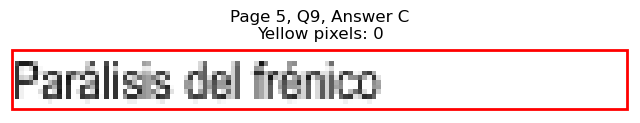

Page 5, Q9 - D: Detected box: x0=327.5, y0=556.5, x1=401.7, y1=569.2
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 356
Page 5, Q9, D: Yellow percentage: 0.0%


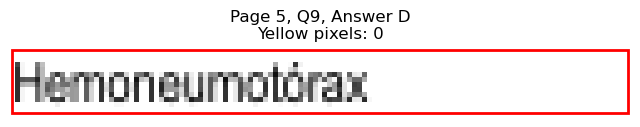


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=594.3, x1=126.0, y1=607.0
Page 5, Q10, A: Yellow pixels: 1173
Page 5, Q10, A: Total non-white pixels: 1417
Page 5, Q10, A: Yellow percentage: 82.8%


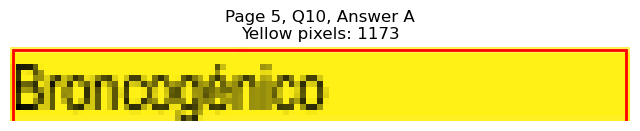

Page 5, Q10 - B: Detected box: x0=68.3, y0=606.9, x1=115.9, y1=619.6
Page 5, Q10, B: Yellow pixels: 94
Page 5, Q10, B: Total non-white pixels: 358
Page 5, Q10, B: Yellow percentage: 26.3%


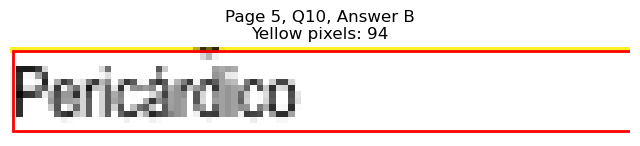

Page 5, Q10 - C: Detected box: x0=327.5, y0=594.3, x1=363.2, y1=607.0
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 172
Page 5, Q10, C: Yellow percentage: 0.0%


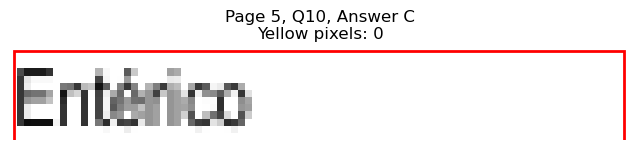

Page 5, Q10 - D: Detected box: x0=327.5, y0=606.9, x1=357.2, y1=619.6
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 135
Page 5, Q10, D: Yellow percentage: 0.0%


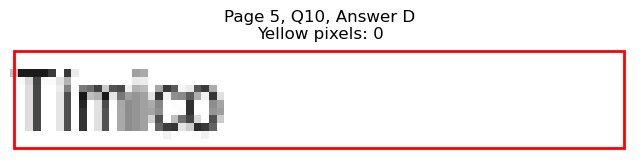


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=177.1, y1=670.1
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 571
Page 5, Q11, A: Yellow percentage: 0.0%


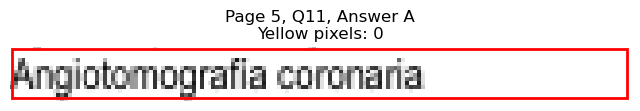

Page 5, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=190.7, y1=682.7
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 609
Page 5, Q11, B: Yellow percentage: 0.0%


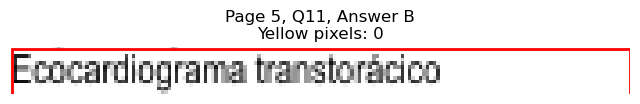

Page 5, Q11 - C: Detected box: x0=327.5, y0=657.5, x1=414.3, y1=670.1
Page 5, Q11, C: Yellow pixels: 138
Page 5, Q11, C: Total non-white pixels: 589
Page 5, Q11, C: Yellow percentage: 23.4%


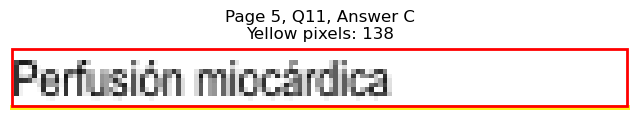

Page 5, Q11 - D: Detected box: x0=327.5, y0=670.1, x1=415.9, y1=682.7
Page 5, Q11, D: Yellow pixels: 1460
Page 5, Q11, D: Total non-white pixels: 1807
Page 5, Q11, D: Yellow percentage: 80.8%


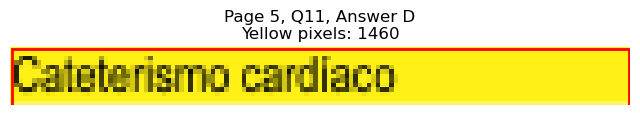


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)




Page 5, Q12 - A: Detected box: x0=68.3, y0=708.0, x1=161.1, y1=720.6
Page 5, Q12, A: Yellow pixels: 1496
Page 5, Q12, A: Total non-white pixels: 2016
Page 5, Q12, A: Yellow percentage: 74.2%


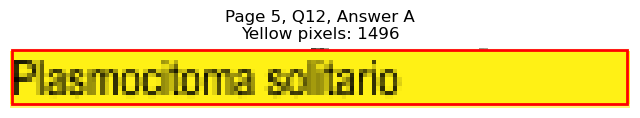

Page 5, Q12 - B: Detected box: x0=68.3, y0=720.6, x1=131.5, y1=733.2
Page 5, Q12, B: Yellow pixels: 114
Page 5, Q12, B: Total non-white pixels: 445
Page 5, Q12, B: Yellow percentage: 25.6%


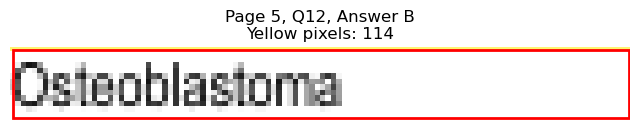

Page 5, Q12 - C: Detected box: x0=327.5, y0=708.0, x1=394.3, y1=720.6
Page 5, Q12, C: Yellow pixels: 0
Page 5, Q12, C: Total non-white pixels: 331
Page 5, Q12, C: Yellow percentage: 0.0%


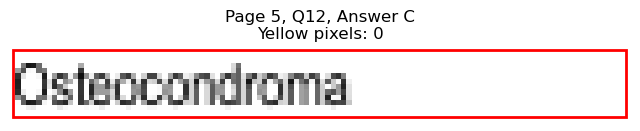

Page 5, Q12 - D: Detected box: x0=327.5, y0=720.6, x1=393.8, y1=733.2
Page 5, Q12, D: Yellow pixels: 0
Page 5, Q12, D: Total non-white pixels: 373
Page 5, Q12, D: Yellow percentage: 0.0%


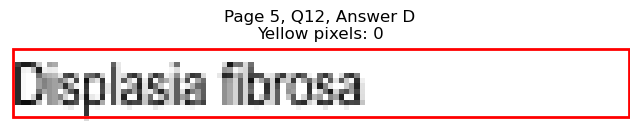


Page 5, Q12 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=146.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 1371
Page 6, Q1, A: Total non-white pixels: 1806
Page 6, Q1, A: Yellow percentage: 75.9%


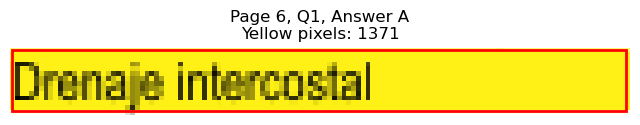

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=171.1, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 681
Page 6, Q1, B: Yellow percentage: 0.0%


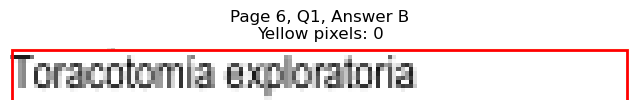

Page 6, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=397.7, y1=102.1
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 353
Page 6, Q1, C: Yellow percentage: 0.0%


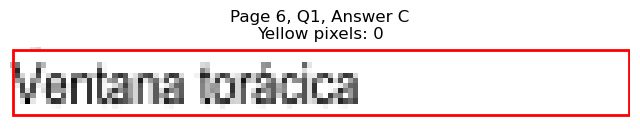

Page 6, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=404.8, y1=114.7
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 401
Page 6, Q1, D: Yellow percentage: 0.0%


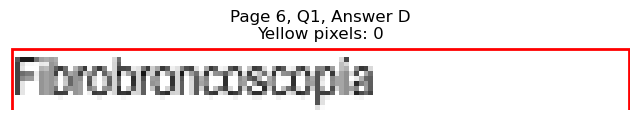


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=334.1, y1=152.6
Page 6, Q2, A: Yellow pixels: 3140
Page 6, Q2, A: Total non-white pixels: 4438
Page 6, Q2, A: Yellow percentage: 70.8%


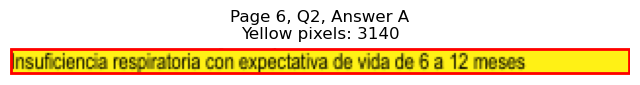

Page 6, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=298.1, y1=165.2
Page 6, Q2, B: Yellow pixels: 281
Page 6, Q2, B: Total non-white pixels: 1452
Page 6, Q2, B: Yellow percentage: 19.4%


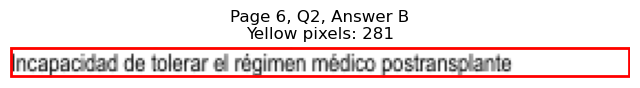

Page 6, Q2 - C: Detected box: x0=68.8, y0=165.1, x1=329.6, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 1353
Page 6, Q2, C: Yellow percentage: 0.0%


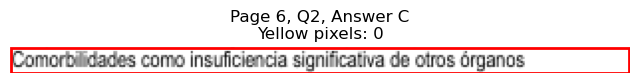

Page 6, Q2 - D: Detected box: x0=68.8, y0=177.7, x1=342.1, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 1342
Page 6, Q2, D: Yellow percentage: 0.0%


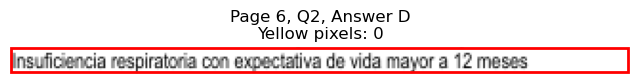


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=120.5, y1=253.5
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 315
Page 6, Q3, A: Yellow percentage: 0.0%


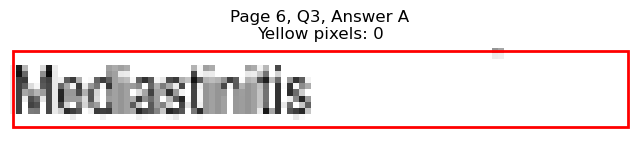

Page 6, Q3 - B: Detected box: x0=68.3, y0=506.0, x1=120.0, y1=518.6
Page 6, Q3, B: Yellow pixels: 102
Page 6, Q3, B: Total non-white pixels: 581
Page 6, Q3, B: Yellow percentage: 17.6%


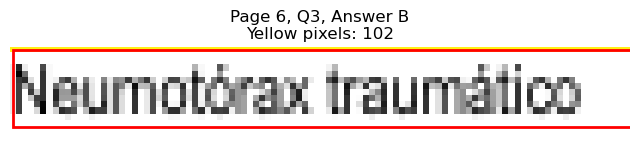

Page 6, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=402.8, y1=253.5
Page 6, Q3, C: Yellow pixels: 1315
Page 6, Q3, C: Total non-white pixels: 1764
Page 6, Q3, C: Yellow percentage: 74.5%


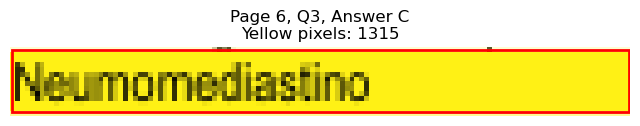

Page 6, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=398.2, y1=266.1
Page 6, Q3, D: Yellow pixels: 122
Page 6, Q3, D: Total non-white pixels: 489
Page 6, Q3, D: Yellow percentage: 24.9%


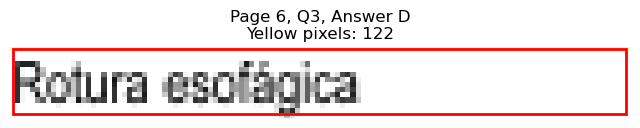


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=153.5, y1=304.1
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 401
Page 6, Q4, A: Yellow percentage: 0.0%


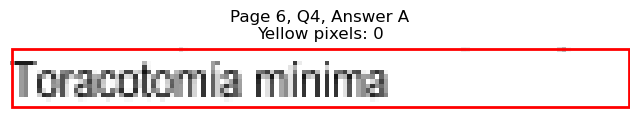

Page 6, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=150.0, y1=316.7
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 401
Page 6, Q4, B: Yellow percentage: 0.0%


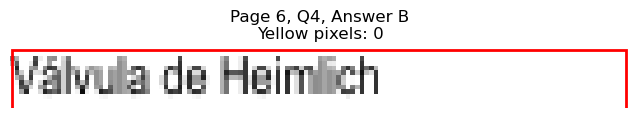

Page 6, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=497.6, y1=304.1
Page 6, Q4, C: Yellow pixels: 2092
Page 6, Q4, C: Total non-white pixels: 2995
Page 6, Q4, C: Yellow percentage: 69.8%


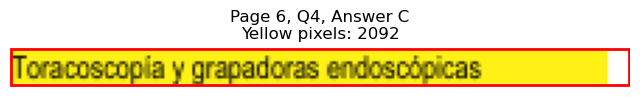

Page 6, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=395.7, y1=316.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 475
Page 6, Q4, D: Yellow percentage: 0.0%


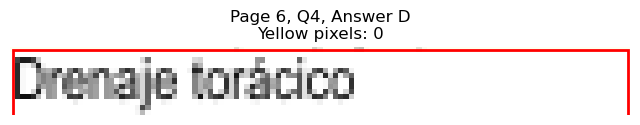


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=84.4, y1=379.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 136
Page 6, Q5, A: Yellow percentage: 0.0%


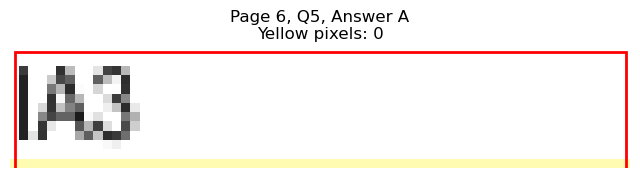

Page 6, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=79.3, y1=392.4
Page 6, Q5, B: Yellow pixels: 701
Page 6, Q5, B: Total non-white pixels: 868
Page 6, Q5, B: Yellow percentage: 80.8%


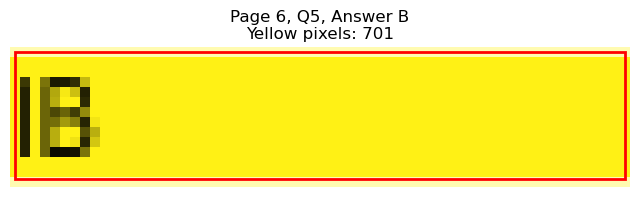

Page 6, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=341.1, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 63
Page 6, Q5, C: Yellow percentage: 0.0%


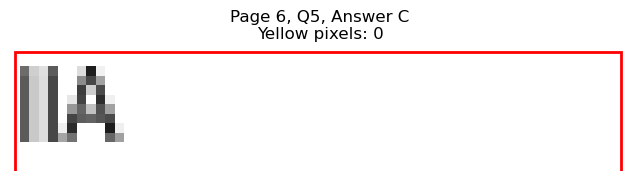

Page 6, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=341.1, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 69
Page 6, Q5, D: Yellow percentage: 0.0%


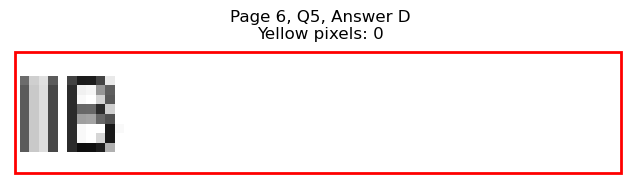


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=263.0, y1=430.3
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 968
Page 6, Q6, A: Yellow percentage: 0.0%


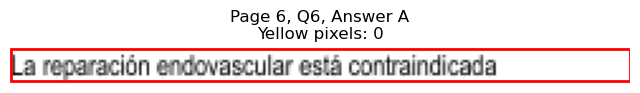

Page 6, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=324.5, y1=442.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 1557
Page 6, Q6, B: Yellow percentage: 0.0%


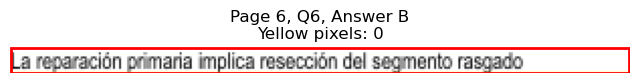

Page 6, Q6 - C: Detected box: x0=68.8, y0=442.8, x1=299.0, y1=455.5
Page 6, Q6, C: Yellow pixels: 2778
Page 6, Q6, C: Total non-white pixels: 3934
Page 6, Q6, C: Yellow percentage: 70.6%


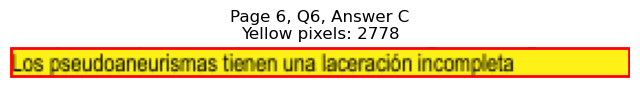

Page 6, Q6 - D: Detected box: x0=68.8, y0=455.5, x1=372.2, y1=468.1
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 1459
Page 6, Q6, D: Yellow percentage: 0.0%


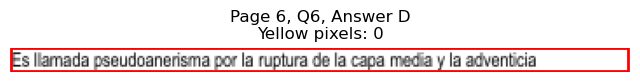


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=166.1, y1=506.0
Page 6, Q7, A: Yellow pixels: 1569
Page 6, Q7, A: Total non-white pixels: 1937
Page 6, Q7, A: Yellow percentage: 81.0%


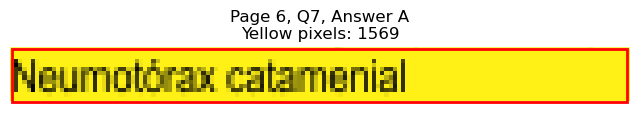

Page 6, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=164.5, y1=518.6
Page 6, Q7, B: Yellow pixels: 147
Page 6, Q7, B: Total non-white pixels: 626
Page 6, Q7, B: Yellow percentage: 23.5%


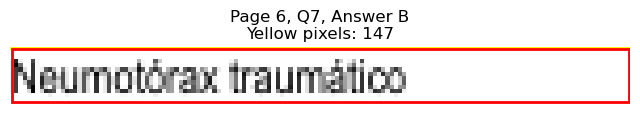

Page 6, Q7 - C: Detected box: x0=327.5, y0=493.4, x1=413.3, y1=506.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 473
Page 6, Q7, C: Yellow percentage: 0.0%


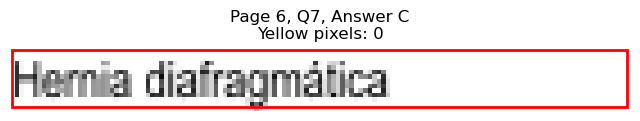

Page 6, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=434.3, y1=518.6
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 582
Page 6, Q7, D: Yellow percentage: 0.0%


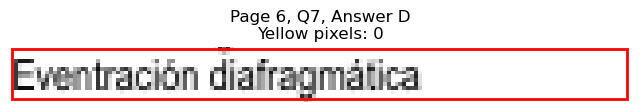


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=112.9, y1=581.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 213
Page 6, Q8, A: Yellow percentage: 0.0%


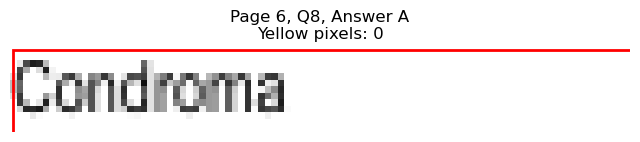

Page 6, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=161.1, y1=594.4
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 486
Page 6, Q8, B: Yellow percentage: 0.0%


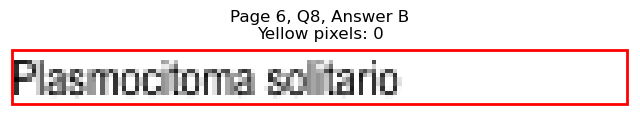

Page 6, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=405.8, y1=581.8
Page 6, Q8, C: Yellow pixels: 1
Page 6, Q8, C: Total non-white pixels: 516
Page 6, Q8, C: Yellow percentage: 0.2%


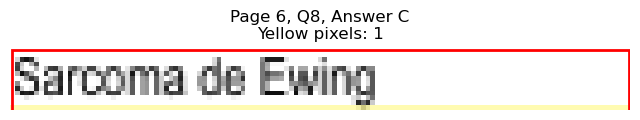

Page 6, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=394.3, y1=594.4
Page 6, Q8, D: Yellow pixels: 1153
Page 6, Q8, D: Total non-white pixels: 1652
Page 6, Q8, D: Yellow percentage: 69.8%


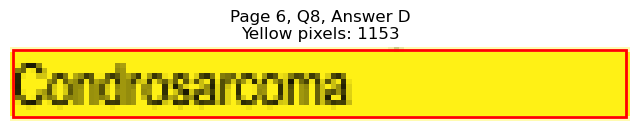


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=225.3, y1=644.9
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 803
Page 6, Q9, A: Yellow percentage: 0.0%


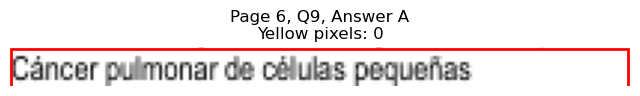

Page 6, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=162.0, y1=657.5
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 463
Page 6, Q9, B: Yellow percentage: 0.0%


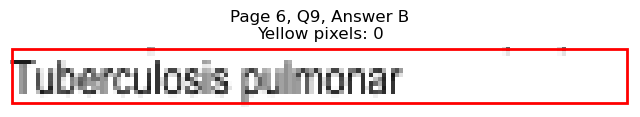

Page 6, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=497.1, y1=644.9
Page 6, Q9, C: Yellow pixels: 2079
Page 6, Q9, C: Total non-white pixels: 2782
Page 6, Q9, C: Yellow percentage: 74.7%


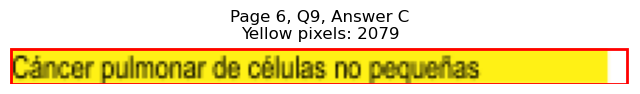

Page 6, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=420.3, y1=657.5
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 505
Page 6, Q9, D: Yellow percentage: 0.0%


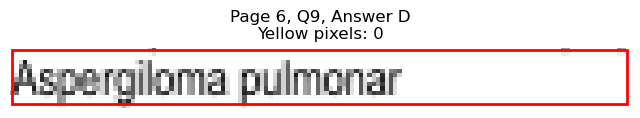


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=135.0, y1=708.0
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 328
Page 6, Q10, A: Yellow percentage: 0.0%


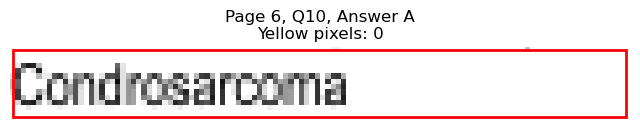

Page 6, Q10 - B: Detected box: x0=68.3, y0=581.7, x1=161.1, y1=594.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 486
Page 6, Q10, B: Yellow percentage: 0.0%


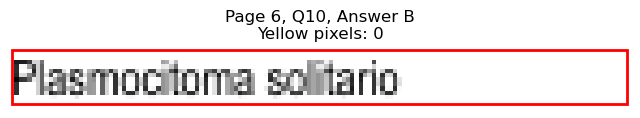

Page 6, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=388.7, y1=708.0
Page 6, Q10, C: Yellow pixels: 112
Page 6, Q10, C: Total non-white pixels: 522
Page 6, Q10, C: Yellow percentage: 21.5%


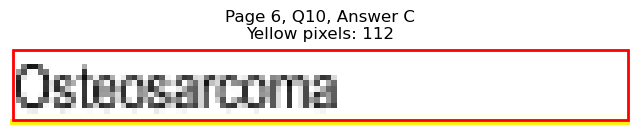

Page 6, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=405.8, y1=720.6
Page 6, Q10, D: Yellow pixels: 1374
Page 6, Q10, D: Total non-white pixels: 1806
Page 6, Q10, D: Yellow percentage: 76.1%


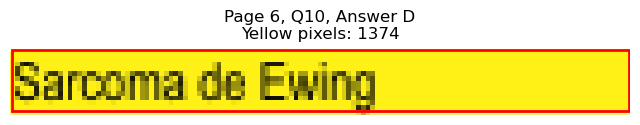


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=222.3, y1=758.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 766
Page 6, Q11, A: Yellow percentage: 0.0%


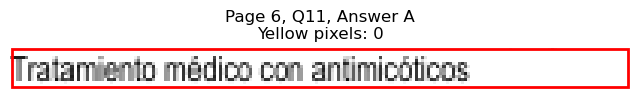

Page 6, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=125.5, y1=771.2
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 285
Page 6, Q11, B: Yellow percentage: 0.0%


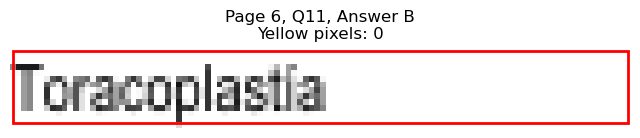

Page 6, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=412.3, y1=758.4
Page 6, Q11, C: Yellow pixels: 1447
Page 6, Q11, C: Total non-white pixels: 1904
Page 6, Q11, C: Yellow percentage: 76.0%


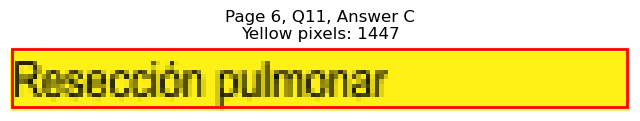

Page 6, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=440.3, y1=771.2
Page 6, Q11, D: Yellow pixels: 164
Page 6, Q11, D: Total non-white pixels: 745
Page 6, Q11, D: Yellow percentage: 22.0%


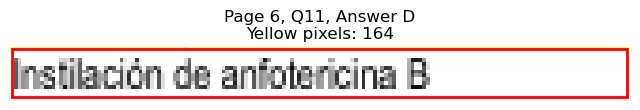


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=205.7, y1=102.1
Page 7, Q1, A: Yellow pixels: 188
Page 7, Q1, A: Total non-white pixels: 900
Page 7, Q1, A: Yellow percentage: 20.9%


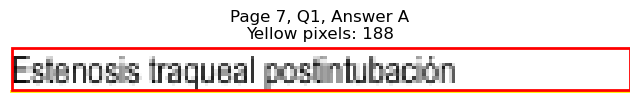

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=185.7, y1=114.7
Page 7, Q1, B: Yellow pixels: 1726
Page 7, Q1, B: Total non-white pixels: 2184
Page 7, Q1, B: Yellow percentage: 79.0%


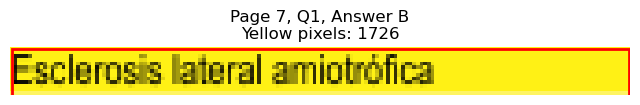

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=446.9, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 600
Page 7, Q1, C: Yellow percentage: 0.0%


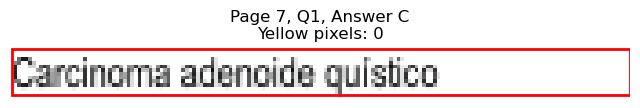

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=425.8, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 499
Page 7, Q1, D: Yellow percentage: 0.0%


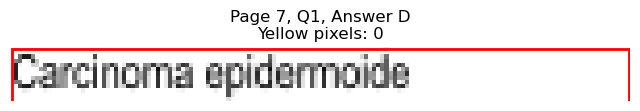


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=119.4, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 301
Page 7, Q2, A: Yellow percentage: 0.0%


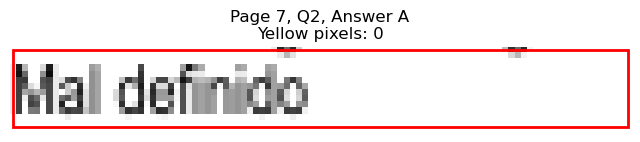

Page 7, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=130.5, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 328
Page 7, Q2, B: Yellow percentage: 0.0%


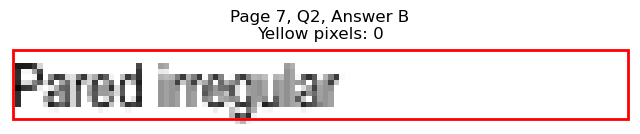

Page 7, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=362.7, y1=152.6
Page 7, Q2, C: Yellow pixels: 86
Page 7, Q2, C: Total non-white pixels: 266
Page 7, Q2, C: Yellow percentage: 32.3%


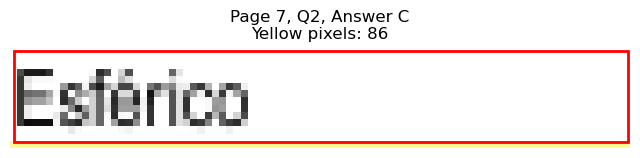

Page 7, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=408.3, y1=165.2
Page 7, Q2, D: Yellow pixels: 1400
Page 7, Q2, D: Total non-white pixels: 1848
Page 7, Q2, D: Yellow percentage: 75.8%


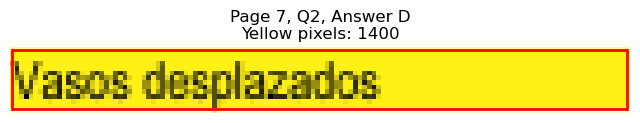


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=138.5, y1=228.3
Page 7, Q3, A: Yellow pixels: 121
Page 7, Q3, A: Total non-white pixels: 467
Page 7, Q3, A: Yellow percentage: 25.9%


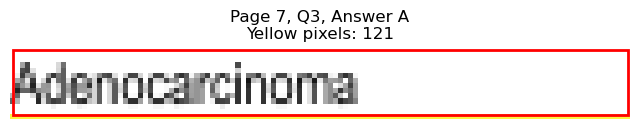

Page 7, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=166.6, y1=240.9
Page 7, Q3, B: Yellow pixels: 1566
Page 7, Q3, B: Total non-white pixels: 1937
Page 7, Q3, B: Yellow percentage: 80.8%


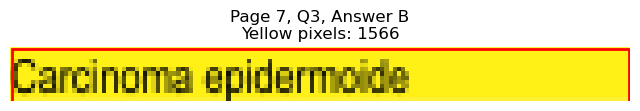

Page 7, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=407.2, y1=228.3
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 416
Page 7, Q3, C: Yellow percentage: 0.0%


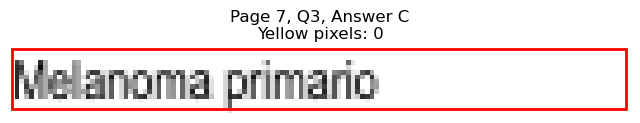

Page 7, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=366.2, y1=240.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 190
Page 7, Q3, D: Yellow percentage: 0.0%


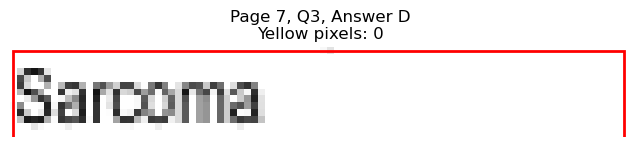


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=134.1, y1=291.5
Page 7, Q4, A: Yellow pixels: 117
Page 7, Q4, A: Total non-white pixels: 423
Page 7, Q4, A: Yellow percentage: 27.7%


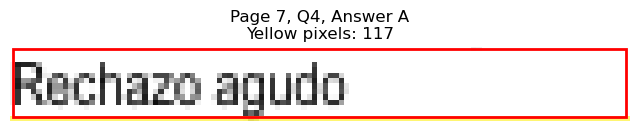

Page 7, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=138.0, y1=304.1
Page 7, Q4, B: Yellow pixels: 1314
Page 7, Q4, B: Total non-white pixels: 1694
Page 7, Q4, B: Yellow percentage: 77.6%


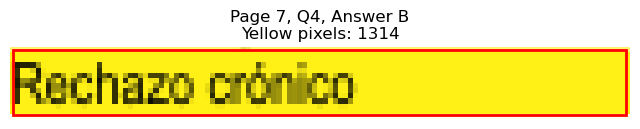

Page 7, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=472.1, y1=291.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 741
Page 7, Q4, C: Yellow percentage: 0.0%


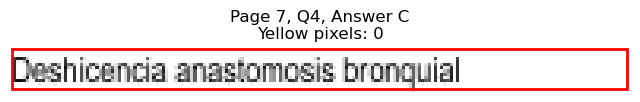

Page 7, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=371.7, y1=304.1
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 221
Page 7, Q4, D: Yellow percentage: 0.0%


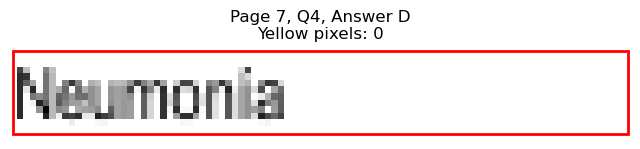


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=81.9, y1=367.2
Page 7, Q5, A: Yellow pixels: 64
Page 7, Q5, A: Total non-white pixels: 129
Page 7, Q5, A: Yellow percentage: 49.6%


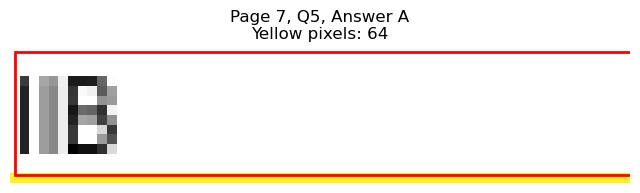

Page 7, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=84.4, y1=379.8
Page 7, Q5, B: Yellow pixels: 813
Page 7, Q5, B: Total non-white pixels: 871
Page 7, Q5, B: Yellow percentage: 93.3%


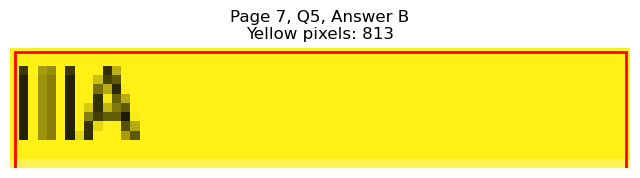

Page 7, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=343.6, y1=367.2
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 88
Page 7, Q5, C: Yellow percentage: 0.0%


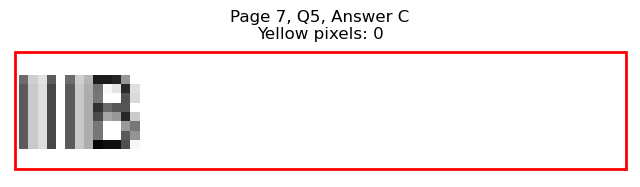

Page 7, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=341.1, y1=379.8
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 63
Page 7, Q5, D: Yellow percentage: 0.0%


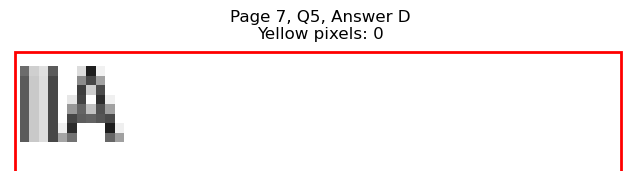


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=169.1, y1=442.9
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 472
Page 7, Q6, A: Yellow percentage: 0.0%


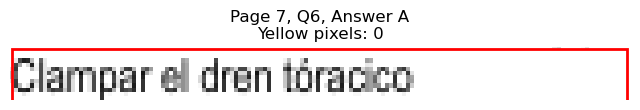

Page 7, Q6 - B: Detected box: x0=68.3, y0=682.7, x1=105.5, y1=695.3
Page 7, Q6, B: Yellow pixels: 88
Page 7, Q6, B: Total non-white pixels: 510
Page 7, Q6, B: Yellow percentage: 17.3%


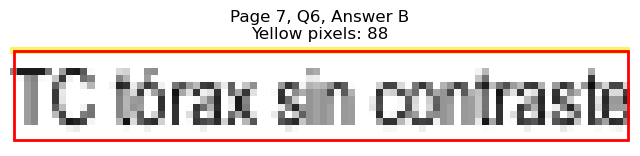

Page 7, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=418.9, y1=442.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 600
Page 7, Q6, C: Yellow percentage: 0.0%


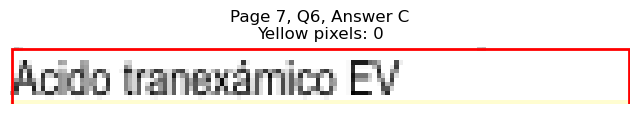

Page 7, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=438.9, y1=455.5
Page 7, Q6, D: Yellow pixels: 1661
Page 7, Q6, D: Total non-white pixels: 2268
Page 7, Q6, D: Yellow percentage: 73.2%


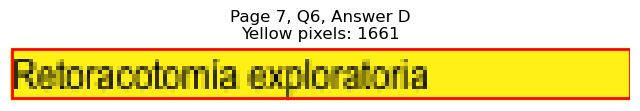


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=493.4, x1=145.6, y1=506.0
Page 7, Q7, A: Yellow pixels: 1353
Page 7, Q7, A: Total non-white pixels: 1665
Page 7, Q7, A: Yellow percentage: 81.3%


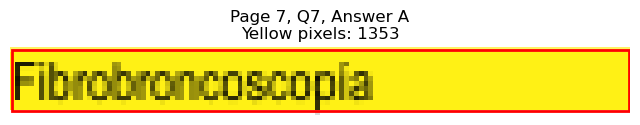

Page 7, Q7 - B: Detected box: x0=68.3, y0=506.0, x1=130.5, y1=518.6
Page 7, Q7, B: Yellow pixels: 112
Page 7, Q7, B: Total non-white pixels: 448
Page 7, Q7, B: Yellow percentage: 25.0%


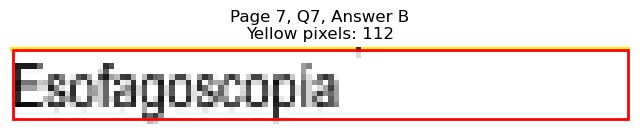

Page 7, Q7 - C: Detected box: x0=327.5, y0=670.1, x1=366.8, y1=682.7
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 430
Page 7, Q7, C: Yellow percentage: 0.0%


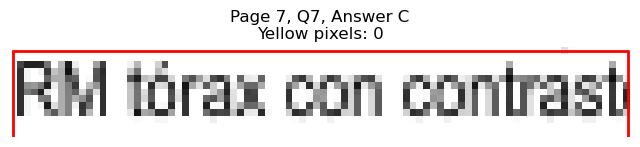

Page 7, Q7 - D: Detected box: x0=327.5, y0=506.0, x1=368.7, y1=518.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 220
Page 7, Q7, D: Yellow percentage: 0.0%


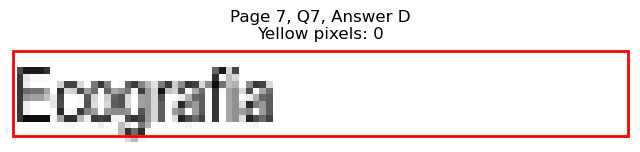


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=204.6, y1=556.4
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 670
Page 7, Q8, A: Yellow percentage: 0.0%


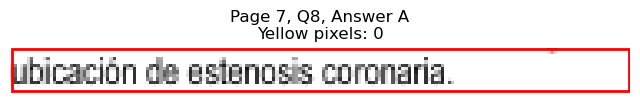

Page 7, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=189.7, y1=569.2
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 601
Page 7, Q8, B: Yellow percentage: 0.0%


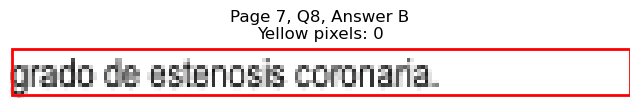

Page 7, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=460.0, y1=556.4
Page 7, Q8, C: Yellow pixels: 1878
Page 7, Q8, C: Total non-white pixels: 2576
Page 7, Q8, C: Yellow percentage: 72.9%


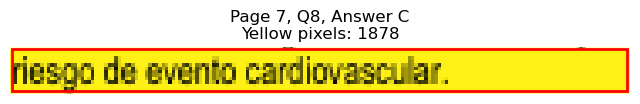

Page 7, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=379.1, y1=569.2
Page 7, Q8, D: Yellow pixels: 102
Page 7, Q8, D: Total non-white pixels: 376
Page 7, Q8, D: Yellow percentage: 27.1%


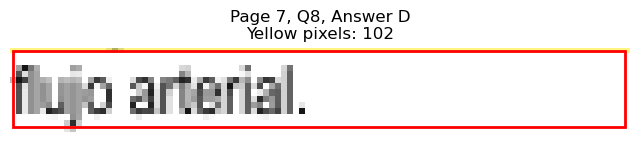


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=303.0, y1=607.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 1094
Page 7, Q9, A: Yellow percentage: 0.0%


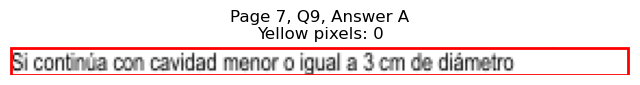

Page 7, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=237.9, y1=619.6
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 811
Page 7, Q9, B: Yellow percentage: 0.0%


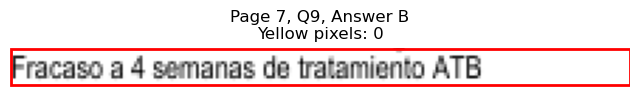

Page 7, Q9 - C: Detected box: x0=68.8, y0=619.6, x1=240.4, y1=632.3
Page 7, Q9, C: Yellow pixels: 2003
Page 7, Q9, C: Total non-white pixels: 3122
Page 7, Q9, C: Yellow percentage: 64.2%


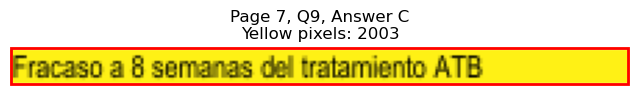

Page 7, Q9 - D: Detected box: x0=68.8, y0=632.2, x1=264.9, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 1208
Page 7, Q9, D: Yellow percentage: 0.0%


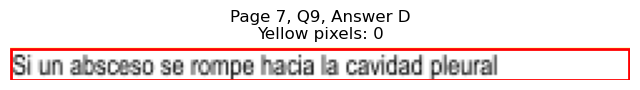


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=162.1, y1=682.7
Page 7, Q10, A: Yellow pixels: 1547
Page 7, Q10, A: Total non-white pixels: 1885
Page 7, Q10, A: Yellow percentage: 82.1%


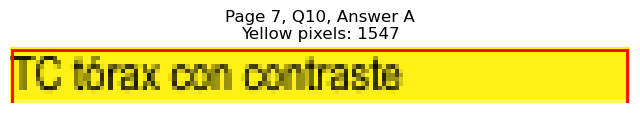

Page 7, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=159.0, y1=695.3
Page 7, Q10, B: Yellow pixels: 142
Page 7, Q10, B: Total non-white pixels: 566
Page 7, Q10, B: Yellow percentage: 25.1%


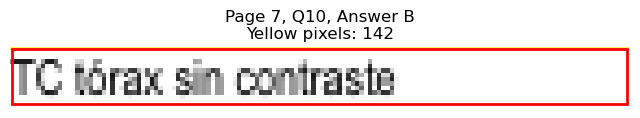

Page 7, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=423.3, y1=682.7
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 452
Page 7, Q10, C: Yellow percentage: 0.0%


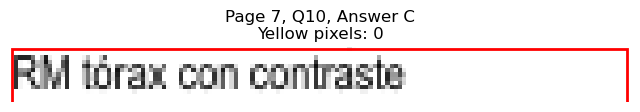

Page 7, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=420.3, y1=695.3
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 447
Page 7, Q10, D: Yellow percentage: 0.0%


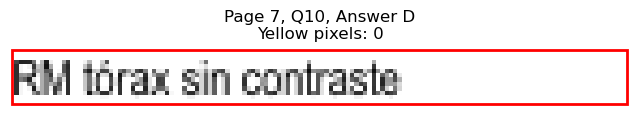


Page 7, Q10 - Selected Answer: A (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=745.8, x1=154.1, y1=758.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 455
Page 7, Q11, A: Yellow percentage: 0.0%


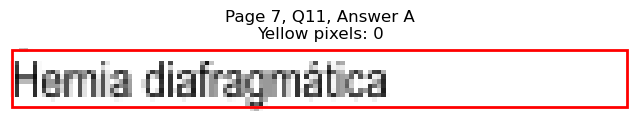

Page 7, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=175.1, y1=771.2
Page 7, Q11, B: Yellow pixels: 1608
Page 7, Q11, B: Total non-white pixels: 2212
Page 7, Q11, B: Yellow percentage: 72.7%


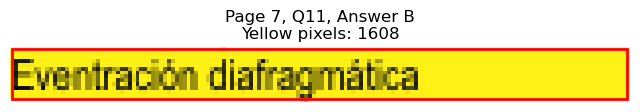

Page 7, Q11 - C: Detected box: x0=327.5, y0=745.8, x1=380.7, y1=758.4
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 282
Page 7, Q11, C: Yellow percentage: 0.0%


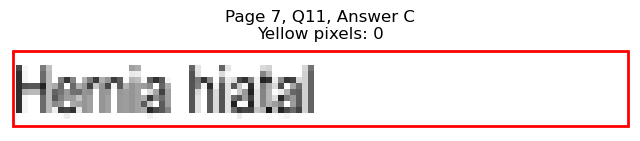

Page 7, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=409.3, y1=771.2
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 435
Page 7, Q11, D: Yellow percentage: 0.0%


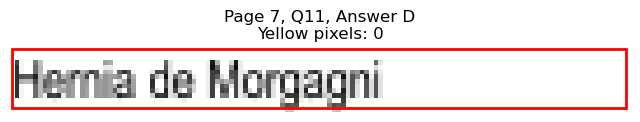


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=152.5, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 452
Page 8, Q1, A: Yellow percentage: 0.0%


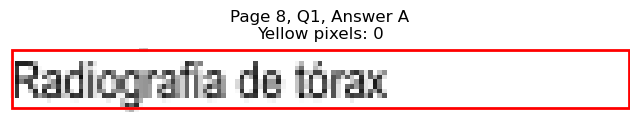

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=117.0, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 234
Page 8, Q1, B: Yellow percentage: 0.0%


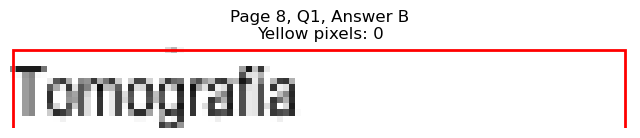

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=402.8, y1=127.3
Page 8, Q1, C: Yellow pixels: 126
Page 8, Q1, C: Total non-white pixels: 519
Page 8, Q1, C: Yellow percentage: 24.3%


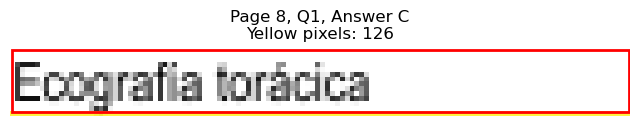

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=434.5, y1=139.9
Page 8, Q1, D: Yellow pixels: 1639
Page 8, Q1, D: Total non-white pixels: 2054
Page 8, Q1, D: Yellow percentage: 79.8%


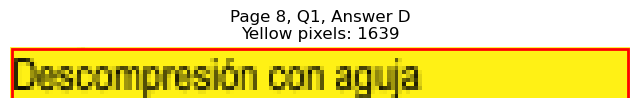


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=137.2, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 354
Page 8, Q2, A: Yellow percentage: 0.0%


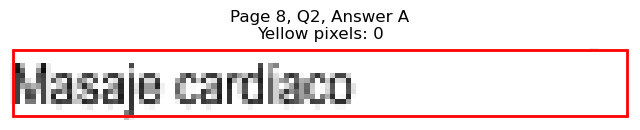

Page 8, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=144.5, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 405
Page 8, Q2, B: Yellow percentage: 0.0%


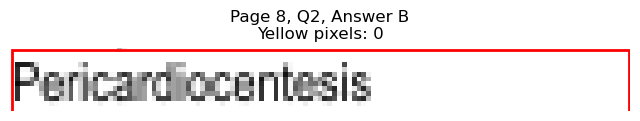

Page 8, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=458.5, y1=190.4
Page 8, Q2, C: Yellow pixels: 182
Page 8, Q2, C: Total non-white pixels: 870
Page 8, Q2, C: Yellow percentage: 20.9%


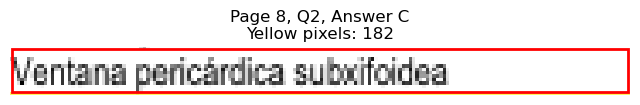

Page 8, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=445.0, y1=203.0
Page 8, Q2, D: Yellow pixels: 1748
Page 8, Q2, D: Total non-white pixels: 2197
Page 8, Q2, D: Yellow percentage: 79.6%


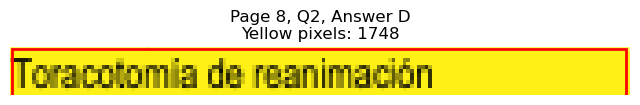


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=163.6, y1=253.5
Page 8, Q3, A: Yellow pixels: 1527
Page 8, Q3, A: Total non-white pixels: 2044
Page 8, Q3, A: Yellow percentage: 74.7%


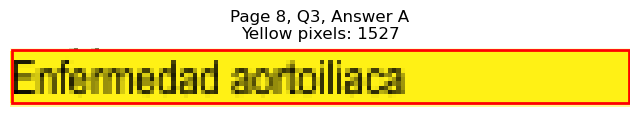

Page 8, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=182.7, y1=266.1
Page 8, Q3, B: Yellow pixels: 165
Page 8, Q3, B: Total non-white pixels: 758
Page 8, Q3, B: Yellow percentage: 21.8%


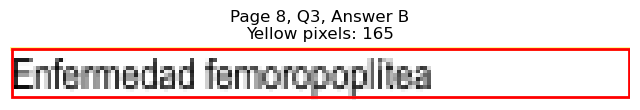

Page 8, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=382.3, y1=253.5
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 297
Page 8, Q3, C: Yellow percentage: 0.0%


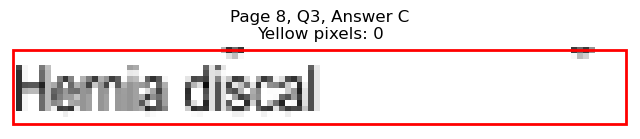

Page 8, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=403.7, y1=266.1
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 367
Page 8, Q3, D: Yellow percentage: 0.0%


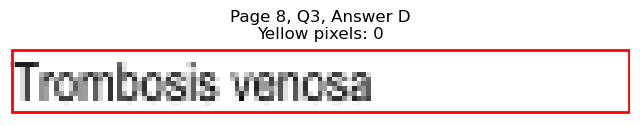


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=138.5, y1=304.1
Page 8, Q4, A: Yellow pixels: 1299
Page 8, Q4, A: Total non-white pixels: 1694
Page 8, Q4, A: Yellow percentage: 76.7%


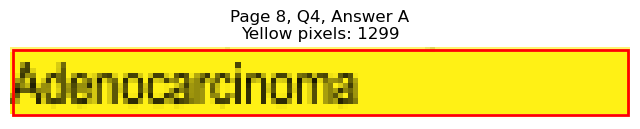

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=199.7, y1=316.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 815
Page 8, Q4, B: Yellow percentage: 0.0%


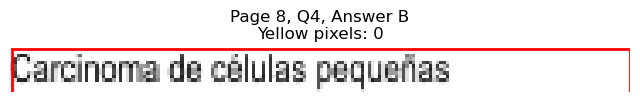

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=425.8, y1=304.1
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 497
Page 8, Q4, C: Yellow percentage: 0.0%


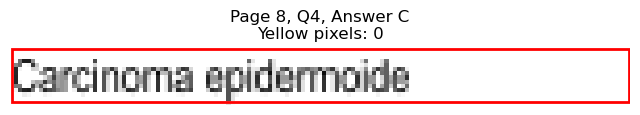

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=517.1, y1=316.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 959
Page 8, Q4, D: Yellow percentage: 0.0%


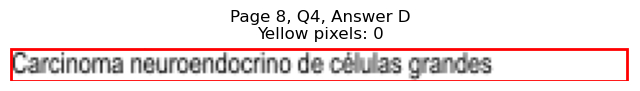


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=173.7, y1=354.6
Page 8, Q5, A: Yellow pixels: 156
Page 8, Q5, A: Total non-white pixels: 685
Page 8, Q5, A: Yellow percentage: 22.8%


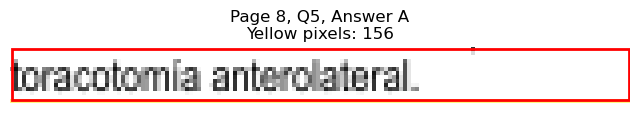

Page 8, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=153.0, y1=367.2
Page 8, Q5, B: Yellow pixels: 1430
Page 8, Q5, B: Total non-white pixels: 1904
Page 8, Q5, B: Yellow percentage: 75.1%


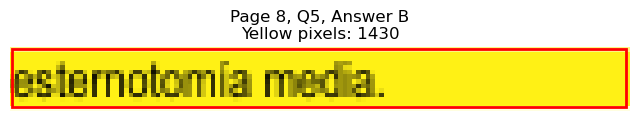

Page 8, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=437.3, y1=354.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 566
Page 8, Q5, C: Yellow percentage: 0.0%


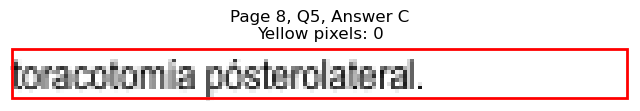

Page 8, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=404.2, y1=367.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 386
Page 8, Q5, D: Yellow percentage: 0.0%


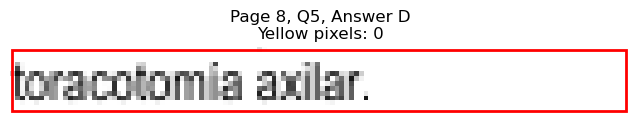


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=145.6, y1=417.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 386
Page 8, Q6, A: Yellow percentage: 0.0%


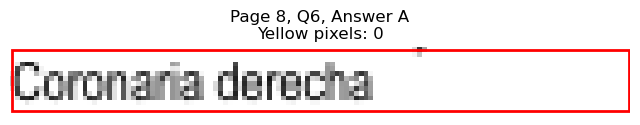

Page 8, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=113.4, y1=430.3
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 228
Page 8, Q6, B: Yellow percentage: 0.0%


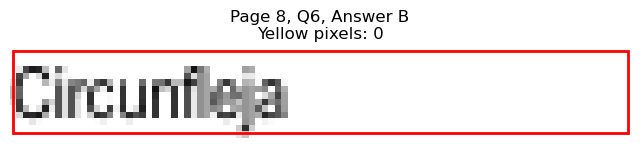

Page 8, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=427.4, y1=417.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 515
Page 8, Q6, C: Yellow percentage: 0.0%


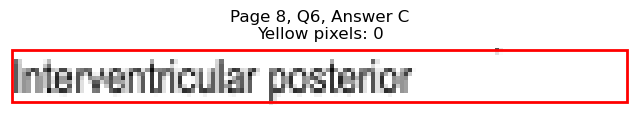

Page 8, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=416.3, y1=430.3
Page 8, Q6, D: Yellow pixels: 1328
Page 8, Q6, D: Total non-white pixels: 1960
Page 8, Q6, D: Yellow percentage: 67.8%


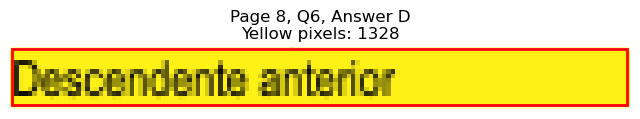


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=112.5, y1=468.1
Page 8, Q7, A: Yellow pixels: 95
Page 8, Q7, A: Total non-white pixels: 318
Page 8, Q7, A: Yellow percentage: 29.9%


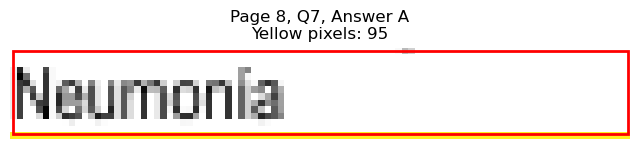

Page 8, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=140.1, y1=480.7
Page 8, Q7, B: Yellow pixels: 1333
Page 8, Q7, B: Total non-white pixels: 1599
Page 8, Q7, B: Yellow percentage: 83.4%


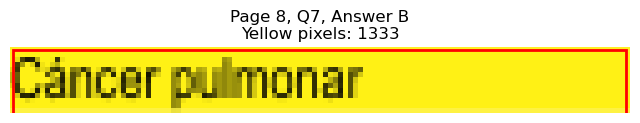

Page 8, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=408.8, y1=468.1
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 423
Page 8, Q7, C: Yellow percentage: 0.0%


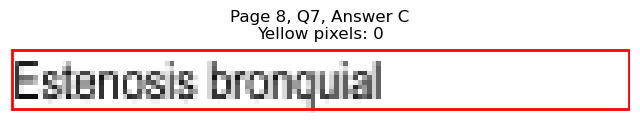

Page 8, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=447.4, y1=480.7
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 601
Page 8, Q7, D: Yellow percentage: 0.0%


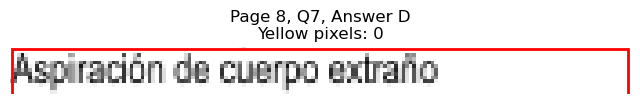


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=137.1, y1=531.2
Page 8, Q8, A: Yellow pixels: 1286
Page 8, Q8, A: Total non-white pixels: 1680
Page 8, Q8, A: Yellow percentage: 76.5%


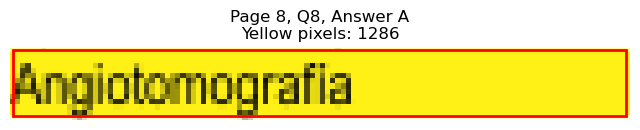

Page 8, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=162.6, y1=543.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 621
Page 8, Q8, B: Yellow percentage: 0.0%


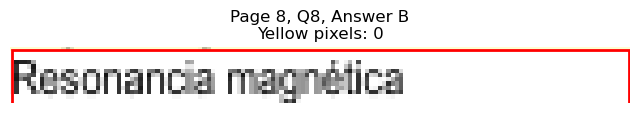

Page 8, Q8 - C: Detected box: x0=327.5, y0=518.6, x1=403.7, y1=531.2
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 381
Page 8, Q8, C: Yellow percentage: 0.0%


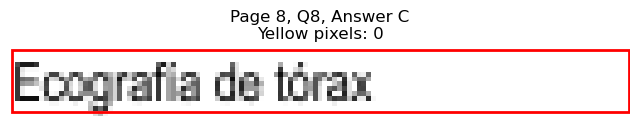

Page 8, Q8 - D: Detected box: x0=327.5, y0=531.2, x1=374.7, y1=543.8
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 249
Page 8, Q8, D: Yellow percentage: 0.0%


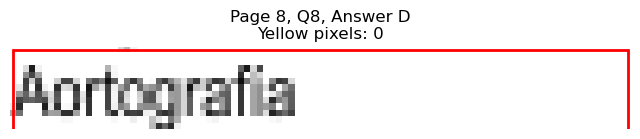


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=149.1, y1=594.4
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 441
Page 8, Q9, A: Yellow percentage: 0.0%


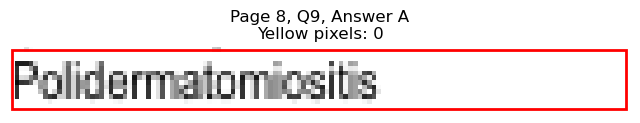

Page 8, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=129.0, y1=607.0
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 312
Page 8, Q9, B: Yellow percentage: 0.0%


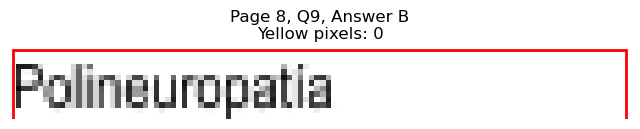

Page 8, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=438.9, y1=594.4
Page 8, Q9, C: Yellow pixels: 162
Page 8, Q9, C: Total non-white pixels: 738
Page 8, Q9, C: Yellow percentage: 22.0%


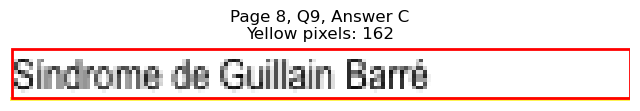

Page 8, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=395.2, y1=607.0
Page 8, Q9, D: Yellow pixels: 1259
Page 8, Q9, D: Total non-white pixels: 1547
Page 8, Q9, D: Yellow percentage: 81.4%


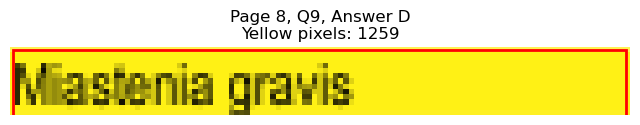


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=130.5, y1=657.5
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 336
Page 8, Q10, A: Yellow percentage: 0.0%


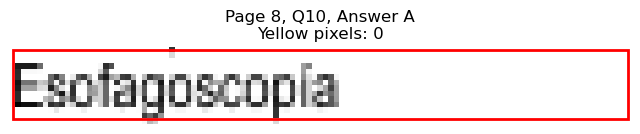

Page 8, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=107.4, y1=670.1
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 195
Page 8, Q10, B: Yellow percentage: 0.0%


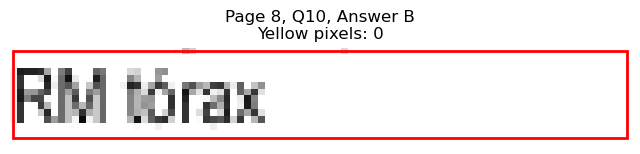

Page 8, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=404.8, y1=657.5
Page 8, Q10, C: Yellow pixels: 1344
Page 8, Q10, C: Total non-white pixels: 1792
Page 8, Q10, C: Yellow percentage: 75.0%


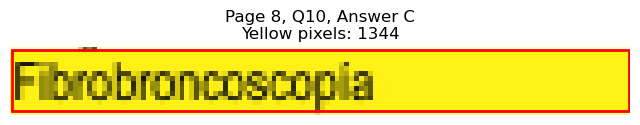

Page 8, Q10 - D: Detected box: x0=327.5, y0=720.6, x1=368.8, y1=733.2
Page 8, Q10, D: Yellow pixels: 92
Page 8, Q10, D: Total non-white pixels: 488
Page 8, Q10, D: Yellow percentage: 18.9%


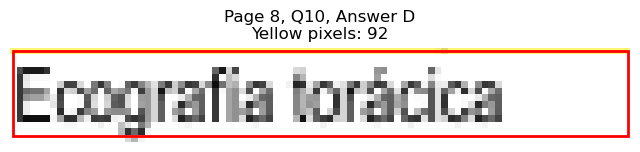


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=105.4, y1=720.6
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 160
Page 8, Q11, A: Yellow percentage: 0.0%


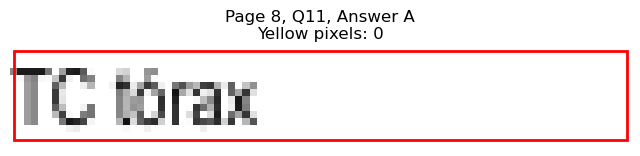

Page 8, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=116.9, y1=733.2
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 228
Page 8, Q11, B: Yellow percentage: 0.0%


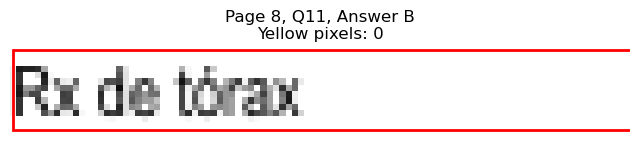

Page 8, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=430.4, y1=720.6
Page 8, Q11, C: Yellow pixels: 1593
Page 8, Q11, C: Total non-white pixels: 2156
Page 8, Q11, C: Yellow percentage: 73.9%


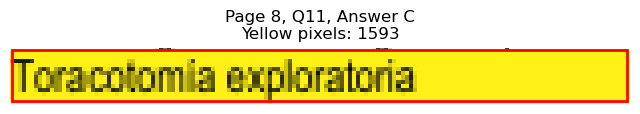

Page 8, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=400.3, y1=733.2
Page 8, Q11, D: Yellow pixels: 124
Page 8, Q11, D: Total non-white pixels: 520
Page 8, Q11, D: Yellow percentage: 23.8%


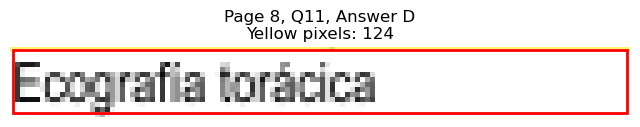


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=115.0, y1=114.7
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 334
Page 9, Q1, A: Yellow percentage: 0.0%


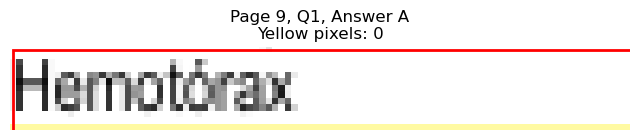

Page 9, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=164.5, y1=127.3
Page 9, Q1, B: Yellow pixels: 1399
Page 9, Q1, B: Total non-white pixels: 2058
Page 9, Q1, B: Yellow percentage: 68.0%


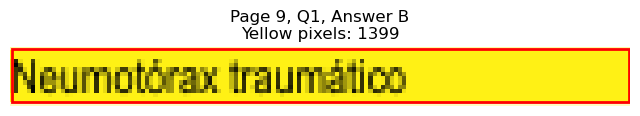

Page 9, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=418.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 461
Page 9, Q1, C: Yellow percentage: 0.0%


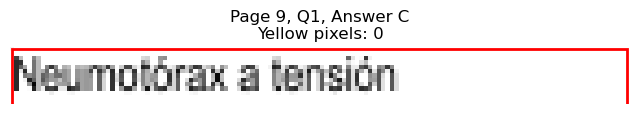

Page 9, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=401.7, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 356
Page 9, Q1, D: Yellow percentage: 0.0%


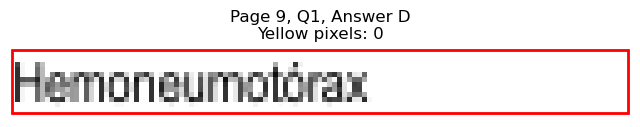


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=188.2, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 640
Page 9, Q2, A: Yellow percentage: 0.0%


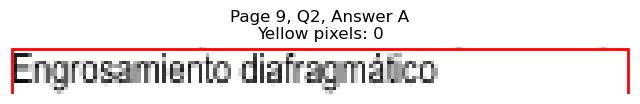

Page 9, Q2 - B: Detected box: x0=68.3, y0=114.6, x1=120.0, y1=127.3
Page 9, Q2, B: Yellow pixels: 871
Page 9, Q2, B: Total non-white pixels: 1442
Page 9, Q2, B: Yellow percentage: 60.4%


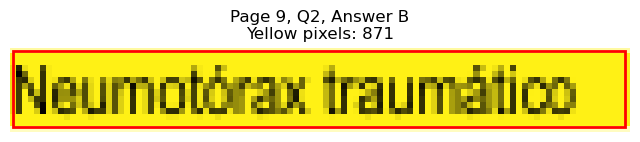

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=446.9, y1=177.8
Page 9, Q2, C: Yellow pixels: 1736
Page 9, Q2, C: Total non-white pixels: 2210
Page 9, Q2, C: Yellow percentage: 78.6%


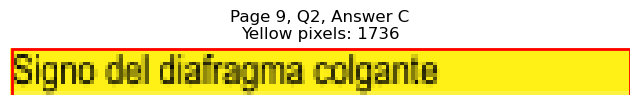

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=413.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 132
Page 9, Q2, D: Total non-white pixels: 610
Page 9, Q2, D: Yellow percentage: 21.6%


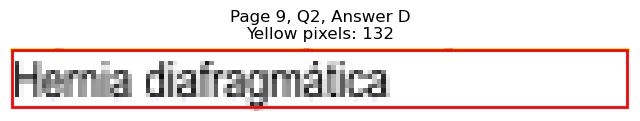


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=147.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 406
Page 9, Q3, A: Yellow percentage: 0.0%


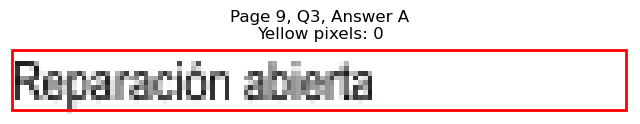

Page 9, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=199.7, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 659
Page 9, Q3, B: Yellow percentage: 0.0%


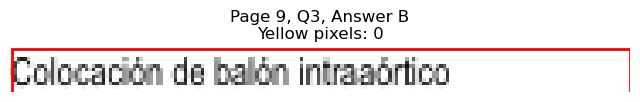

Page 9, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=432.4, y1=228.3
Page 9, Q3, C: Yellow pixels: 1452
Page 9, Q3, C: Total non-white pixels: 2184
Page 9, Q3, C: Yellow percentage: 66.5%


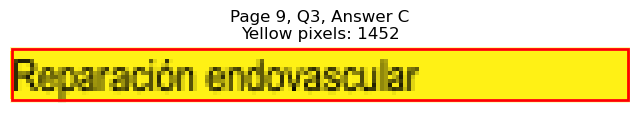

Page 9, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=462.4, y1=240.9
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 835
Page 9, Q3, D: Yellow percentage: 0.0%


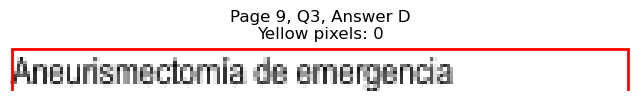


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=164.1, y1=291.5
Page 9, Q4, A: Yellow pixels: 1534
Page 9, Q4, A: Total non-white pixels: 2058
Page 9, Q4, A: Yellow percentage: 74.5%


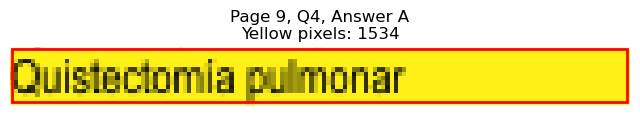

Page 9, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=160.6, y1=304.1
Page 9, Q4, B: Yellow pixels: 143
Page 9, Q4, B: Total non-white pixels: 634
Page 9, Q4, B: Yellow percentage: 22.6%


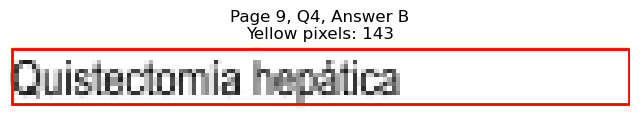

Page 9, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=417.3, y1=291.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 431
Page 9, Q4, C: Yellow percentage: 0.0%


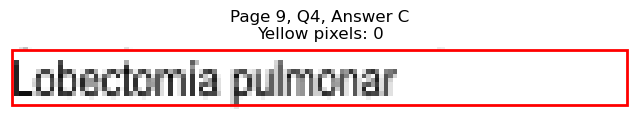

Page 9, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=412.3, y1=304.1
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 435
Page 9, Q4, D: Yellow percentage: 0.0%


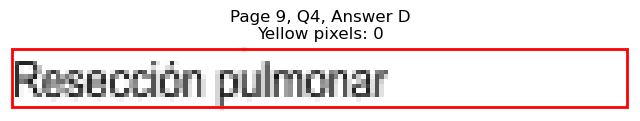


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=182.7, y1=354.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 567
Page 9, Q5, A: Yellow percentage: 0.0%


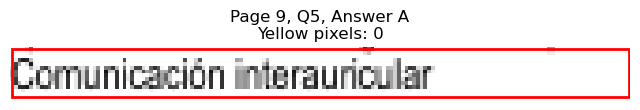

Page 9, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=148.6, y1=367.2
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 390
Page 9, Q5, B: Yellow percentage: 0.0%


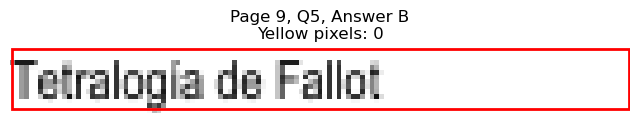

Page 9, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=451.4, y1=354.6
Page 9, Q5, C: Yellow pixels: 1758
Page 9, Q5, C: Total non-white pixels: 2450
Page 9, Q5, C: Yellow percentage: 71.8%


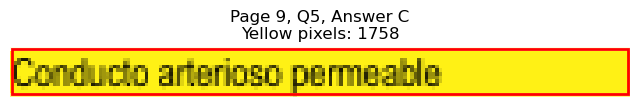

Page 9, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=409.3, y1=367.2
Page 9, Q5, D: Yellow pixels: 133
Page 9, Q5, D: Total non-white pixels: 532
Page 9, Q5, D: Yellow percentage: 25.0%


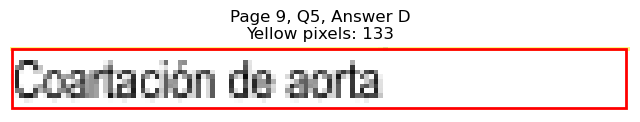


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=129.5, y1=417.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 317
Page 9, Q6, A: Yellow percentage: 0.0%


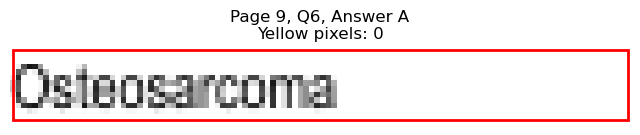

Page 9, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=135.0, y1=430.3
Page 9, Q6, B: Yellow pixels: 1146
Page 9, Q6, B: Total non-white pixels: 1652
Page 9, Q6, B: Yellow percentage: 69.4%


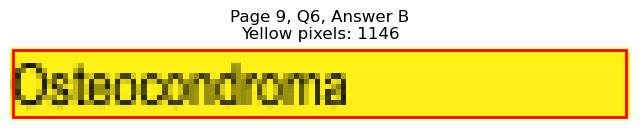

Page 9, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=436.9, y1=417.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 552
Page 9, Q6, C: Yellow percentage: 0.0%


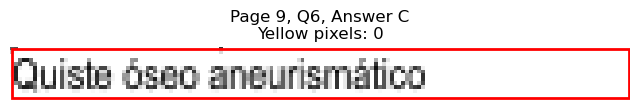

Page 9, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=415.3, y1=430.3
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 437
Page 9, Q6, D: Yellow percentage: 0.0%


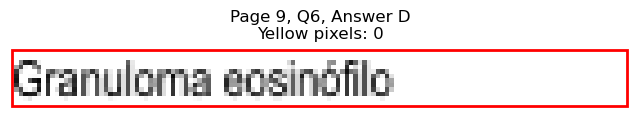


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=148.1, y1=493.4
Page 9, Q7, A: Yellow pixels: 1232
Page 9, Q7, A: Total non-white pixels: 1834
Page 9, Q7, A: Yellow percentage: 67.2%


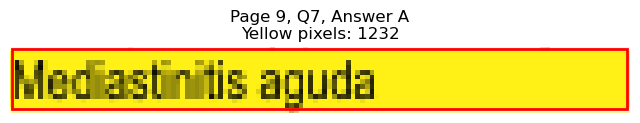

Page 9, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=153.6, y1=506.0
Page 9, Q7, B: Yellow pixels: 1
Page 9, Q7, B: Total non-white pixels: 592
Page 9, Q7, B: Yellow percentage: 0.2%


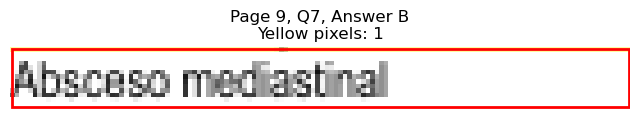

Page 9, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=402.8, y1=493.4
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 399
Page 9, Q7, C: Yellow percentage: 0.0%


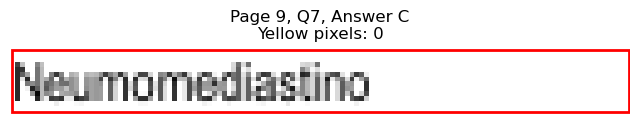

Page 9, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=397.7, y1=506.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 372
Page 9, Q7, D: Yellow percentage: 0.0%


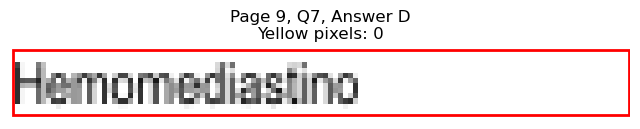


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=144.6, y1=556.4
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 419
Page 9, Q8, A: Yellow percentage: 0.0%


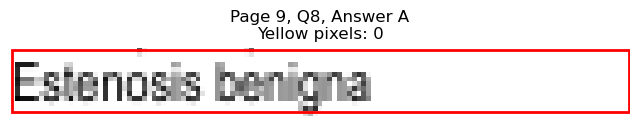

Page 9, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=145.1, y1=569.2
Page 9, Q8, B: Yellow pixels: 1361
Page 9, Q8, B: Total non-white pixels: 1792
Page 9, Q8, B: Yellow percentage: 75.9%


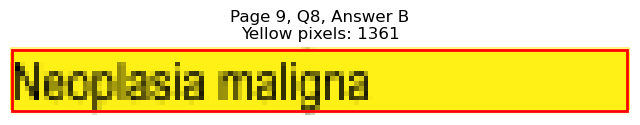

Page 9, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=377.2, y1=556.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 252
Page 9, Q8, C: Yellow percentage: 0.0%


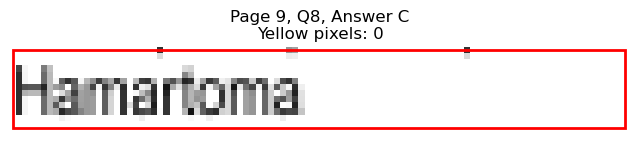

Page 9, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=383.7, y1=569.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 276
Page 9, Q8, D: Yellow percentage: 0.0%


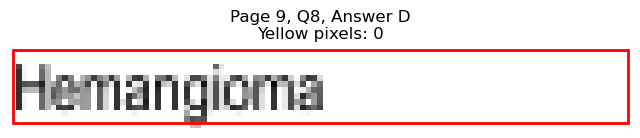


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=119.9, y1=607.0
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 375
Page 9, Q9, A: Yellow percentage: 0.0%


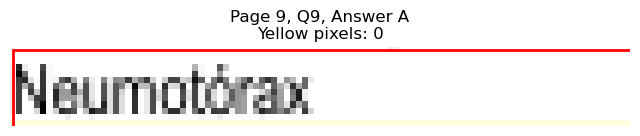

Page 9, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=165.1, y1=619.6
Page 9, Q9, B: Yellow pixels: 1558
Page 9, Q9, B: Total non-white pixels: 2072
Page 9, Q9, B: Yellow percentage: 75.2%


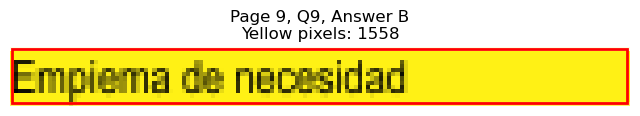

Page 9, Q9 - C: Detected box: x0=327.5, y0=594.3, x1=371.2, y1=607.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 223
Page 9, Q9, C: Yellow percentage: 0.0%


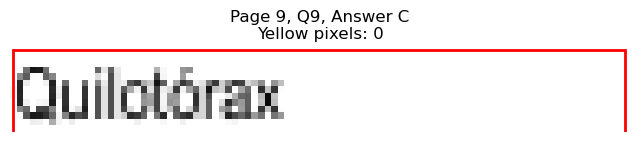

Page 9, Q9 - D: Detected box: x0=327.5, y0=606.9, x1=374.2, y1=619.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 233
Page 9, Q9, D: Yellow percentage: 0.0%


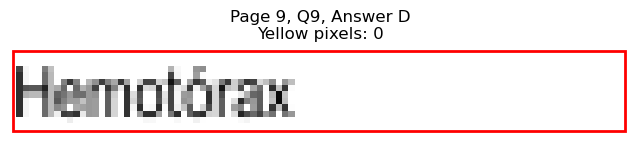


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=164.1, y1=670.1
Page 9, Q10, A: Yellow pixels: 1534
Page 9, Q10, A: Total non-white pixels: 2058
Page 9, Q10, A: Yellow percentage: 74.5%


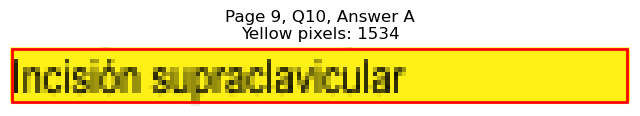

Page 9, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=174.1, y1=682.7
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 694
Page 9, Q10, B: Yellow percentage: 0.0%


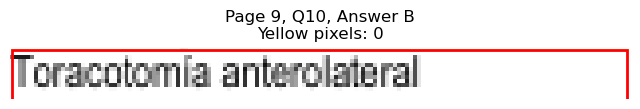

Page 9, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=437.8, y1=670.1
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 567
Page 9, Q10, C: Yellow percentage: 0.0%


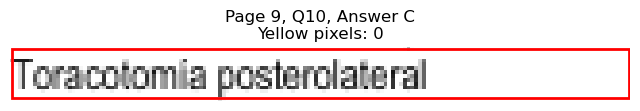

Page 9, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=410.8, y1=682.7
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 430
Page 9, Q10, D: Yellow percentage: 0.0%


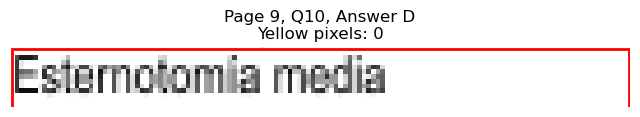


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es la causa más frecuente de tratamiento...
1   Varón de 53 años, con traumatismo torácico cer...
2   ¿Cuál es el abordaje para el control proximal ...
3   Mujer de 65 años con antecedentes de tabaquism...
4   Mujer de 58 años. Antecedente: hace dos años t...
..                                                ...
95  Mujer 38 años con masa en región anterolateral...
96  Mujer de 65 años, obesa, con antecedente de ci...
97  Varón de 55 años, ingresa por presentar disnea...
98             ¿Cuál es una complicación del empiema?
99  Varón de 25 años que sufre herida por arma bla...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Intensa caseificación y cavitación   
1                      Neumonía severa   
2           Toracotomía posterolateral   
3                                    3   
4                       Asma bronquial   
..                                 ...   
95                        Osteosarcoma   
96                 Mediastinitis aguda   
97                   Estenosis benigna   
98                          Neumotórax   
99            Incisión supraclavicular   

                                     option_B  \
0    Hemoptisis masiva intratable médicamente   
1   Síndrome de dificultad respiratoria aguda   
2                          Toracotomía axilar   
3                                           4   
4                           Fibrosis pulmonar   
..                                        ...   
95                              Osteocondroma   
96                        Absceso mediastinal   
97                          Neoplasia maligna   
98                       Empiema de necesidad   
99                  Toracotomía anterolateral   

                                   option_C                           option_D  
0   Infección secundaria de bronquiectasias  Empiema más fístula broncopleural  
1                           Tórax inestable         Insuficiencia ventilatoria  
2                           Supraclavicular                       Esternotomía  
3                                         2                                  1  
4   Enfermedad pulmonar obstructiva crónica                 Estenosis traqueal  
..                                      ...                                ...  
95                Quiste óseo aneurismático               Granuloma eosinófilo  
96                          Neumomediastino                     Hemomediastino  
97                                Hamartoma                         Hemangioma  
98                               Quilotórax                          Hemotórax  
99               Toracotomía posterolateral                 Esternotomía media  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   ¿Cuál es la causa más frecuente de tratamiento...   
1   Varón de 53 años, con traumatismo torácico cer...   
2   ¿Cuál es el abordaje para el control proximal ...   
3   Mujer de 65 años con antecedentes de tabaquism...   
4   Mujer de 58 años. Antecedente: hace dos años t...   
..                                                ...   
95  Mujer 38 años con masa en región anterolateral...   
96  Mujer de 65 años, obesa, con antecedente de ci...   
97  Varón de 55 años, ingresa por presentar disnea...   
98             ¿Cuál es una complicación del empiema?   
99  Varón de 25 años que sufre herida por arma bla...   

                              option_A  \
0   Intensa caseificación y cavitación   
1                      Neumonía severa   
2           Toracotomía posterolateral   
3                                    3   
4                       Asma bronquial   
..                                 ...   
95                        Osteosarcoma   
96                 Mediastinitis aguda   
97                   Estenosis benigna   
98                          Neumotórax   
99            Incisión supraclavicular   

                                     option_B  \
0    Hemoptisis masiva intratable médicamente   
1   Síndrome de dificultad respiratoria aguda   
2                          Toracotomía axilar   
3                                           4   
4                           Fibrosis pulmonar   
..                                        ...   
95                              Osteocondroma   
96                        Absceso mediastinal   
97                          Neoplasia maligna   
98                       Empiema de necesidad   
99                  Toracotomía anterolateral   

                                   option_C  \
0   Infección secundaria de bronquiectasias   
1                           Tórax inestable   
2                           Supraclavicular   
3                                         2   
4   Enfermedad pulmonar obstructiva crónica   
..                                      ...   
95                Quiste óseo aneurismático   
96                          Neumomediastino   
97                                Hamartoma   
98                               Quilotórax   
99               Toracotomía posterolateral   

                             option_D correct_answer  
0   Empiema más fístula broncopleural              B  
1          Insuficiencia ventilatoria              B  
2                        Esternotomía              A  
3                                   1              A  
4                  Estenosis traqueal              D  
..                                ...            ...  
95               Granuloma eosinófilo              B  
96                     Hemomediastino              A  
97                         Hemangioma              B  
98                          Hemotórax              B  
99                 Esternotomía media              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA DE TORAX.csv
